 ## Strømanalyse for Olav Tryggvasons gate

 Preprossering

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Skru av warnings (veldig plagsomt)

# Importerer biblioteker
# Datahåndtering og visualisering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# API-håndtering
import requests
from Data.credentials import credentials

# tidsformatør
import matplotlib.dates as mdates
from src.frost import FrostDataRetriver

# matematiske modeller og statistikk
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from math import sqrt


 ### Et datasett representer hvordan de andre kommer til å se ut

In [2]:
# Leser inn data fra desember som mal
df = pd.read_excel("Data/Straum/des.xls", skiprows=6)
df.tail()


,Tidspunkt,Forbruk (kWh),Pris (øre/kWh),Nettleie* (øre/kWh)
742,2025-12-31 22:00,1.494,66.8138,30.54
743,2025-12-31 23:00,1.469,72.8450,30.54
744,NaN,NaN,NaN,NaN
745,NaN,NaN,NaN,NaN
746,"* Nettleiepriser kan avvike, ikke inkludert ev...",NaN,NaN,NaN


In [3]:
# Dropper NaN, de siste tre radene og setter indeks lik tidspunkt
df_clean = df.dropna()
df_clean.set_index("Tidspunkt", inplace=True)
df_clean.tail()


,Forbruk (kWh),Pris (øre/kWh),Nettleie* (øre/kWh)
Tidspunkt,,,
2025-12-31 19:00,1.544,71.3150,44.41
2025-12-31 20:00,2.772,66.9650,44.41
2025-12-31 21:00,2.137,67.0313,44.41
2025-12-31 22:00,1.494,66.8138,30.54
2025-12-31 23:00,1.469,72.8450,30.54


In [4]:
# Skifter navn på 'Nettleie' kolonne
df_clean.rename(columns={"Nettleie* (øre/kWh)": "Nettleie (øre/kWh)"}, inplace=True)
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 744 entries, 2025-12-01 00:00 to 2025-12-31 23:00
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Forbruk (kWh)       744 non-null    float64
 1   Pris (øre/kWh)      744 non-null    float64
 2   Nettleie (øre/kWh)  744 non-null    float64
dtypes: float64(3)
memory usage: 23.2+ KB


 ### Alle datasettene

In [5]:
# Dette er for desember, la oss følge den generiske oppskriften for hele tidsserien og spleise til et stort datasett
months = ["Aug", "Nov", "Okt", "Sep"]

for month in months:
    df_month = pd.read_excel(f"Data/Straum/{month}.xls", skiprows=6)
    df_month_clean = df_month.dropna()
    df_month_clean.set_index("Tidspunkt", inplace=True)
    df_month_clean.rename(
        columns={"Nettleie* (øre/kWh)": "Nettleie (øre/kWh)"},
        inplace=True,
    )
    df_clean = pd.concat([df_clean, df_month_clean])

df_clean.sort_index(inplace=True)


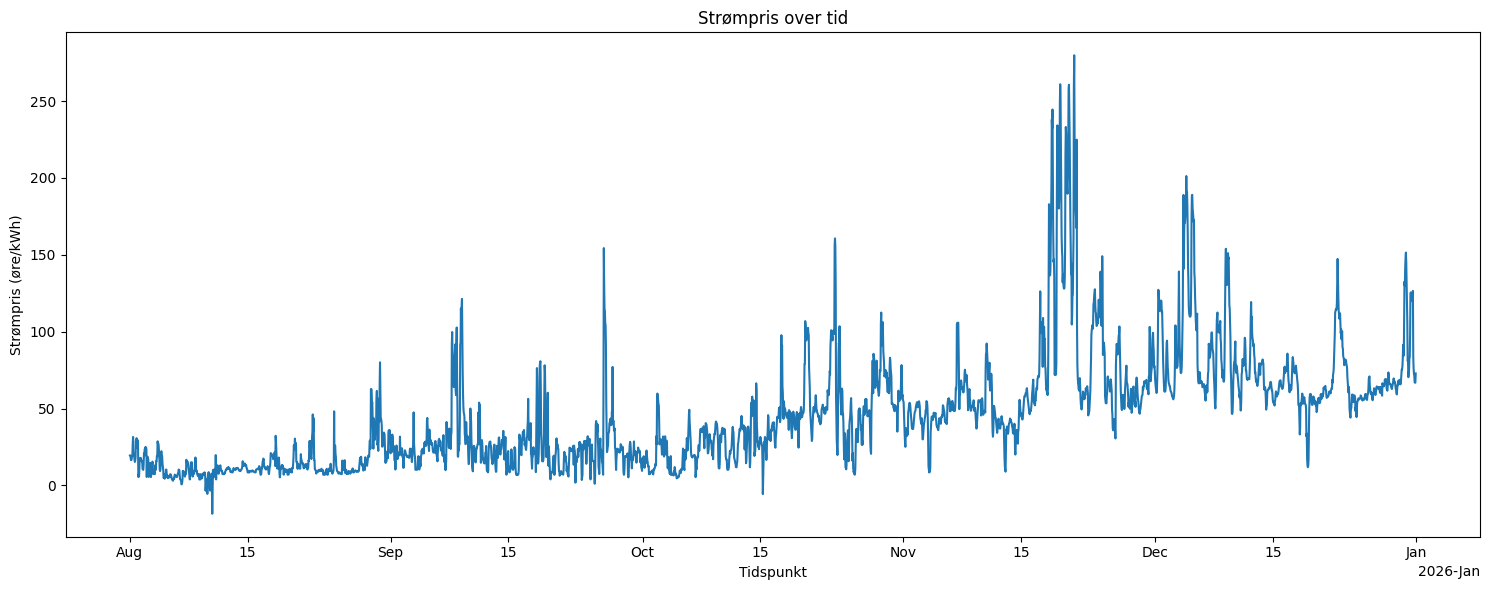

In [6]:
# Strømpris over tid (rå data, ingen manipulering)
df_plot = df_clean.copy()
df_plot.index = pd.to_datetime(df_plot.index, errors="coerce")
df_plot = df_plot.sort_index()

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df_plot.index, df_plot["Pris (øre/kWh)"])
ax.set_xlabel("Tidspunkt")
ax.set_ylabel("Strømpris (øre/kWh)")
ax.set_title("Strømpris over tid")

# Lesbar x-akse med automatisk datolokator og konsis formatter
locator = mdates.AutoDateLocator(minticks=24)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


 #### Basert på dette virker det som dataen stemmer overens med tidene -> Vi kan analysere



 ## Korrelasjonanalyse

 - La oss hente inn temperaturdata

In [7]:
LAT = 63.433302
LON = 10.398091

frost = FrostDataRetriver(credentials["ID"], credentials["SECRET"])
stations = frost.get_stations(LAT, LON, 3)
stations_df = pd.DataFrame(stations)
display(stations_df)


2026-02-18 15:31:13,297 - frost - INFO - FrostDataRetriver initialisert
2026-02-18 15:31:13,302 - frost - INFO - Henter stasjoner nær (63.433302, 10.398091), max=3
2026-02-18 15:31:15,323 - frost - INFO - Suksess: Hentet 3 records fra Frost API


,@type,id,name,shortName,country,countryCode,geometry,distance,masl,validFrom,county,countyId,municipality,municipalityId,ontologyId,stationHolders,externalIds,wigosId
0,SensorSystem,SN68173,TRONDHEIM - GLØSHAUGEN,Gløshaugen,Norge,NO,"{'@type': 'Point', 'coordinates': [10.4072, 63...",2.052383,60,2015-12-15T00:00:00.000Z,TRØNDELAG,50,TRONDHEIM,5001,0,[MET.NO],[10.249.0.58],0-578-0-68173
1,SensorSystem,SN68050,LADE,Lade,Norge,NO,"{'@type': 'Point', 'coordinates': [10.4428, 63...",2.461168,13,2004-11-01T00:00:00.000Z,TRØNDELAG,50,TRONDHEIM,5001,0,[TRONDHEIM KOMMUNE],NaN,0-578-0-68050
2,SensorSystem,SN68125,SVERRESBORG,Sverresborg,Norge,NO,"{'@type': 'Point', 'coordinates': [10.3498, 63...",2.695606,156,2007-07-01T00:00:00.000Z,TRØNDELAG,50,TRONDHEIM,5001,0,[TRONDHEIM KOMMUNE],NaN,0-578-0-68125


In [8]:
results = []

for station_id in stations_df["id"]:
    ts = frost.get_available_period(station_id)
    ts_df = pd.DataFrame(ts)

    # Lag liste over alle elementId for stasjonen
    elements_list = ts_df["elementId"].unique().tolist()

    results.append(
        {
            "station_id": station_id,
            "station_name": stations_df[stations_df["id"] == station_id]["name"].values[0],
            "elements": elements_list,
        }
    )

# Vis tabell ryddig
df_all_elements = pd.DataFrame(results)

pd.set_option("display.max_colwidth", None)  # For å se hele listen i 'elements'
display(df_all_elements)


2026-02-18 15:31:15,337 - frost - INFO - Henter tilgjengelige perioder for stasjon: SN68173
2026-02-18 15:31:15,705 - frost - INFO - Suksess: Hentet 34 records fra Frost API
2026-02-18 15:31:15,707 - frost - INFO - Henter tilgjengelige perioder for stasjon: SN68050
2026-02-18 15:31:16,203 - frost - INFO - Suksess: Hentet 154 records fra Frost API
2026-02-18 15:31:16,204 - frost - INFO - Henter tilgjengelige perioder for stasjon: SN68125
2026-02-18 15:31:16,681 - frost - INFO - Suksess: Hentet 155 records fra Frost API


,station_id,station_name,elements
0,SN68173,TRONDHEIM - GLØSHAUGEN,"[sum(duration_of_sunshine PT1M), instrument_temperature_shortwave_radiation, sum(duration_of_sunshine PT1H), sum(duration_of_sunshine P1M), mean(surface_downwelling_longwave_flux_in_air PT1H), mean(surface_downwelling_shortwave_flux_in_air PT1M), sum(duration_of_sunshine P1D), mean(surface_downwelling_longwave_flux_in_air PT1M), mean(surface_downwelling_shortwave_flux_in_air PT1H), mean(surface_upwelling_longwave_flux_in_air PT1M), battery_voltage, mean(difference_between_downwelling_longwave_flux_and_instrument_longwave_radiation PT1M), instrument_temperature_longwave_radiation, max(sum(duration_of_sunshine P1D) P1M), min(sum(duration_of_sunshine P1D) P1M)]"
1,SN68050,LADE,"[relative_humidity, integral_of_deficit(mean(air_temperature P1D) P1Y 17.0), sum(precipitation_amount P3M), sum(precipitation_amount P1D), best_estimate_mean(air_temperature_anomaly P1Y 1961_1990), dew_point_temperature, sum(precipitation_amount P1Y), max(air_temperature PT12H), max(air_temperature P6M), sum(precipitation_amount PT1H), min(air_temperature P1D), min(air_temperature P1Y), max(surface_snow_thickness P1M), sum(precipitation_amount_anomaly P6M 1991_2020), mean(air_temperature P1M), min(air_temperature P1M), min(air_temperature PT12H), mean(air_temperature_anomaly P3M 1991_2020), max(relative_humidity P1D), sum(precipitation_amount P1M), max(air_temperature PT1H), over_time(sum(time_of_maximum_precipitation_amount P1D) P1M), best_estimate_mean(air_temperature_anomaly P6M 1961_1990), integral_of_deficit(mean(air_temperature P1D) P1D 17.0), min(air_temperature PT1H), min(relative_humidity P1M), sum(precipitation_amount P30D), mean(air_temperature P6M), mean(air_temperature P1Y), min(surface_snow_thickness P1M), best_estimate_sum(precipitation_amount P3M), number_of_days_gte(sum(precipitation_amount P1D) P1M 1.0), air_temperature, min(air_temperature P6M), best_estimate_mean(air_temperature P3M), mean(air_temperature_anomaly P1Y 1961_1990), sum(precipitation_amount PT1M), mean(dew_point_temperature P1M), mean(air_temperature_anomaly P6M 1961_1990), best_estimate_sum(precipitation_amount P1M), best_estimate_mean(air_temperature_anomaly P1M 1961_1990), mean(air_temperature P1D), sum(precipitation_amount_anomaly P1M 1991_2020), max(sum(precipitation_amount P1D) P1M), integral_of_excess(mean(air_temperature P1D) P1D 5.0), mean(air_temperature_anomaly P3M 1961_1990), max(air_temperature P1D), integral_of_deficit(mean(air_temperature P1D) P1M 17.0), max(air_temperature P1Y), integral_of_excess(mean(air_temperature P1D) P1D 0.0), min(relative_humidity P1D), min(air_temperature P3M), sum(precipitation_amount PT12H), integral_of_deficit(mean(air_temperature P1D) P3M 17.0), max(air_temperature P3M), max(air_temperature P1M), mean(surface_snow_thickness P1M), best_estimate_sum(precipitation_amount P1Y), mean(air_temperature_anomaly P1M 1991_2020), over_time(time_of_minimum_air_temperature P1M), max(relative_humidity P1M), sum(precipitation_amount_anomaly P1Y 1991_2020), mean(max(air_temperature P1D) P1M), best_estimate_sum(precipitation_amount P6M), best_estimate_mean(air_temperature_anomaly P3M 1961_1990), sum(precipitation_amount_anomaly P3M 1991_2020), mean(relative_humidity P1D), over_time(time_of_maximum_air_temperature P1M), integral_of_excess(mean(air_temperature P1D) P1M 0.0), mean(min(air_temperature P1D) P1M), mean(air_temperature P3M), mean(water_vapor_partial_pressure_in_air P1M), surface_snow_thickness, integral_of_deficit(mean(air_temperature P1D) P6M 17.0), sum(precipitation_amount P6M), mean(dew_point_temperature P1D), mean(relative_humidity P1M), mean(water_vapor_partial_pressure_in_air P1D), integral_of_excess(mean(air_temperature P1D) P1M 5.0), mean(air_temperature_anomaly P1Y 1991_2020), best_estimate_mean(air_temperature P1Y), best_estimate_mean(air_temperature P1M), mean(air_temperature_anomaly P6M 1991_2020)]"
2,SN68125,SVERRESBORG,"[over_time(time_of_minimum_air_temper

 Jeg fant disse på lade:

 sum(precipitation_amount PT1H), mean(air_temperature P1D), min(air_temperature PT1H), max(air_temperature PT1H)

In [9]:
stations = df_all_elements["station_id"].tolist()

WANTED_ELEMENTS = [
    "air_temperature",
    "relative_humidity",
    "sum(precipitation_amount PT1H)",
    "wind_speed",
]

data_frames = []

df_clean.index = pd.to_datetime(df_clean.index)
START = df_clean.index.min().isoformat()
END = df_clean.index.max().isoformat()

for station in df_all_elements["station_id"]:
    # Finn hvilke elementer stasjonen faktisk støtter
    supported = set(
        df_all_elements.loc[df_all_elements["station_id"] == station, "elements"].values[0]
    )

    elements = [e for e in WANTED_ELEMENTS if e in supported]
    if not elements:
        continue

    data = frost.get_observations_df(
        sources=station,
        elements=",".join(elements),
        start=START,
        end=END,
    )

    if not data.empty:
        data["station_id"] = station
        data_frames.append(data)


2026-02-18 15:31:16,693 - frost - INFO - Henter data for SN68050 med elementer: air_temperature,relative_humidity,sum(precipitation_amount PT1H)
2026-02-18 15:31:18,493 - frost - INFO - Suksess: Hentet 3671 records fra Frost API
2026-02-18 15:31:18,513 - frost - INFO - Hentet og renset observasjoner: 3671 rader, 3 kolonner
2026-02-18 15:31:18,516 - frost - INFO - Henter data for SN68125 med elementer: air_temperature,relative_humidity,sum(precipitation_amount PT1H)
2026-02-18 15:31:20,537 - frost - INFO - Suksess: Hentet 3671 records fra Frost API
2026-02-18 15:31:20,551 - frost - INFO - Hentet og renset observasjoner: 3671 rader, 3 kolonner


In [10]:
df_weather = data_frames[0]  # Starter med første dataframe
df_weather.head()


elementId,air_temperature,relative_humidity,sum(precipitation_amount PT1H),station_id
referenceTime,,,,
2025-08-01 00:00:00+00:00,16.9,95.0,0.0,SN68050
2025-08-01 01:00:00+00:00,16.6,96.0,0.0,SN68050
2025-08-01 02:00:00+00:00,16.3,97.0,0.0,SN68050
2025-08-01 03:00:00+00:00,16.6,98.0,0.0,SN68050
2025-08-01 04:00:00+00:00,16.9,96.0,0.0,SN68050


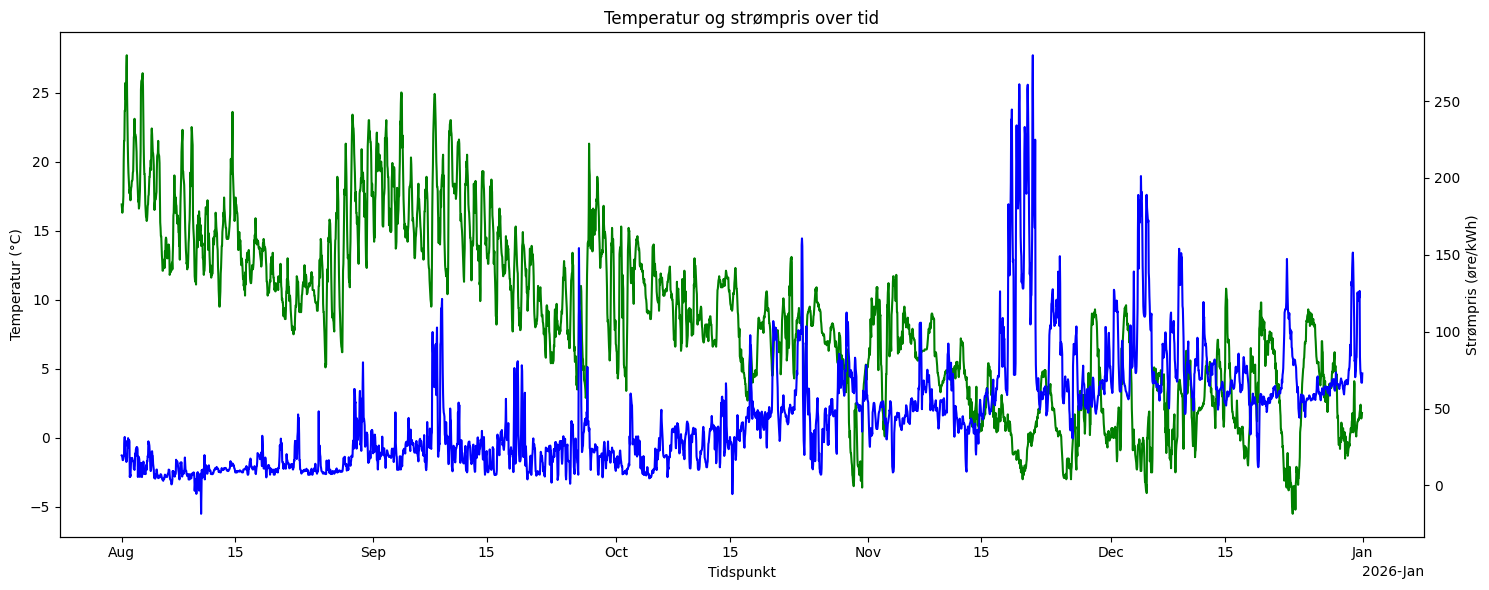

In [11]:
# Plotter temperatur og strømpris over tid
fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

ax1.plot(df_weather.index, df_weather["air_temperature"], "g-", label="Lufttemperatur (°C)")
ax2.plot(df_clean.index, df_clean["Pris (øre/kWh)"], "b-", label="Strømpris (øre/kWh)")

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

ax1.set_xlabel("Tidspunkt")
ax1.set_ylabel("Temperatur (°C)")
ax2.set_ylabel("Strømpris (øre/kWh)")

plt.title("Temperatur og strømpris over tid")
plt.tight_layout()
plt.show()


 Okey, da kan vi starte å analysere

 korrelasjon

In [12]:
print(df_clean.index.dtype)
print(df_weather.index.dtype)


datetime64[ns]
datetime64[ns, UTC]


In [13]:
df_weather.index = df_weather.index.tz_convert(None)


In [14]:
df_weather.index = pd.to_datetime(df_weather.index)
df_clean.index = pd.to_datetime(df_clean.index)

df_weather = df_weather.sort_index()
df_clean = df_clean.sort_index()

# lagrer værdata
df_weather.to_csv("Data/temperatur/weather_data.csv")

df_merged = pd.merge_asof(
    df_clean,           # strømdata (left)
    df_weather,         # værdata (right)
    left_index=True,
    right_index=True,
    direction="nearest",
    tolerance=pd.Timedelta("1H"),
)


In [15]:
df_merged.isna().sum()


Forbruk (kWh)                     0
Pris (øre/kWh)                    0
Nettleie (øre/kWh)                0
air_temperature                   0
relative_humidity                 0
sum(precipitation_amount PT1H)    1
station_id                        0
dtype: int64

In [16]:
df_merged[df_merged["sum(precipitation_amount PT1H)"].isna()]


,Forbruk (kWh),Pris (øre/kWh),Nettleie (øre/kWh),air_temperature,relative_humidity,sum(precipitation_amount PT1H),station_id
Tidspunkt,,,,,,,
2025-08-12 05:00:00,0.272,7.3575,36.04,11.9,87.0,NaN,SN68050


In [17]:
df_merged.tail()


,Forbruk (kWh),Pris (øre/kWh),Nettleie (øre/kWh),air_temperature,relative_humidity,sum(precipitation_amount PT1H),station_id
Tidspunkt,,,,,,,
2025-12-31 19:00:00,1.544,71.3150,44.41,1.8,84.0,0.0,SN68050
2025-12-31 20:00:00,2.772,66.9650,44.41,1.4,82.0,0.0,SN68050
2025-12-31 21:00:00,2.137,67.0313,44.41,1.6,77.0,0.0,SN68050
2025-12-31 22:00:00,1.494,66.8138,30.54,1.8,72.0,0.0,SN68050
2025-12-31 23:00:00,1.469,72.8450,30.54,1.8,72.0,0.0,SN68050


In [18]:
df_merged["sum(precipitation_amount PT1H)"] = df_merged["sum(precipitation_amount PT1H)"].interpolate(
    method="time"
)
df_merged.isna().sum()


Forbruk (kWh)                     0
Pris (øre/kWh)                    0
Nettleie (øre/kWh)                0
air_temperature                   0
relative_humidity                 0
sum(precipitation_amount PT1H)    0
station_id                        0
dtype: int64

In [19]:
df_merged.head()


,Forbruk (kWh),Pris (øre/kWh),Nettleie (øre/kWh),air_temperature,relative_humidity,sum(precipitation_amount PT1H),station_id
Tidspunkt,,,,,,,
2025-08-01 00:00:00,0.083,19.4875,36.04,16.9,95.0,0.0,SN68050
2025-08-01 01:00:00,0.083,19.1038,36.04,16.6,96.0,0.0,SN68050
2025-08-01 02:00:00,0.082,18.1887,36.04,16.3,97.0,0.0,SN68050
2025-08-01 03:00:00,0.084,16.4350,36.04,16.6,98.0,0.0,SN68050
2025-08-01 04:00:00,0.082,16.4638,36.04,16.9,96.0,0.0,SN68050


In [20]:
df_merged.drop("station_id", axis=1, inplace=True)


In [21]:
df_merged.head()


,Forbruk (kWh),Pris (øre/kWh),Nettleie (øre/kWh),air_temperature,relative_humidity,sum(precipitation_amount PT1H)
Tidspunkt,,,,,,
2025-08-01 00:00:00,0.083,19.4875,36.04,16.9,95.0,0.0
2025-08-01 01:00:00,0.083,19.1038,36.04,16.6,96.0,0.0
2025-08-01 02:00:00,0.082,18.1887,36.04,16.3,97.0,0.0
2025-08-01 03:00:00,0.084,16.4350,36.04,16.6,98.0,0.0
2025-08-01 04:00:00,0.082,16.4638,36.04,16.9,96.0,0.0


 Exploratory Data Analysis (EDA)

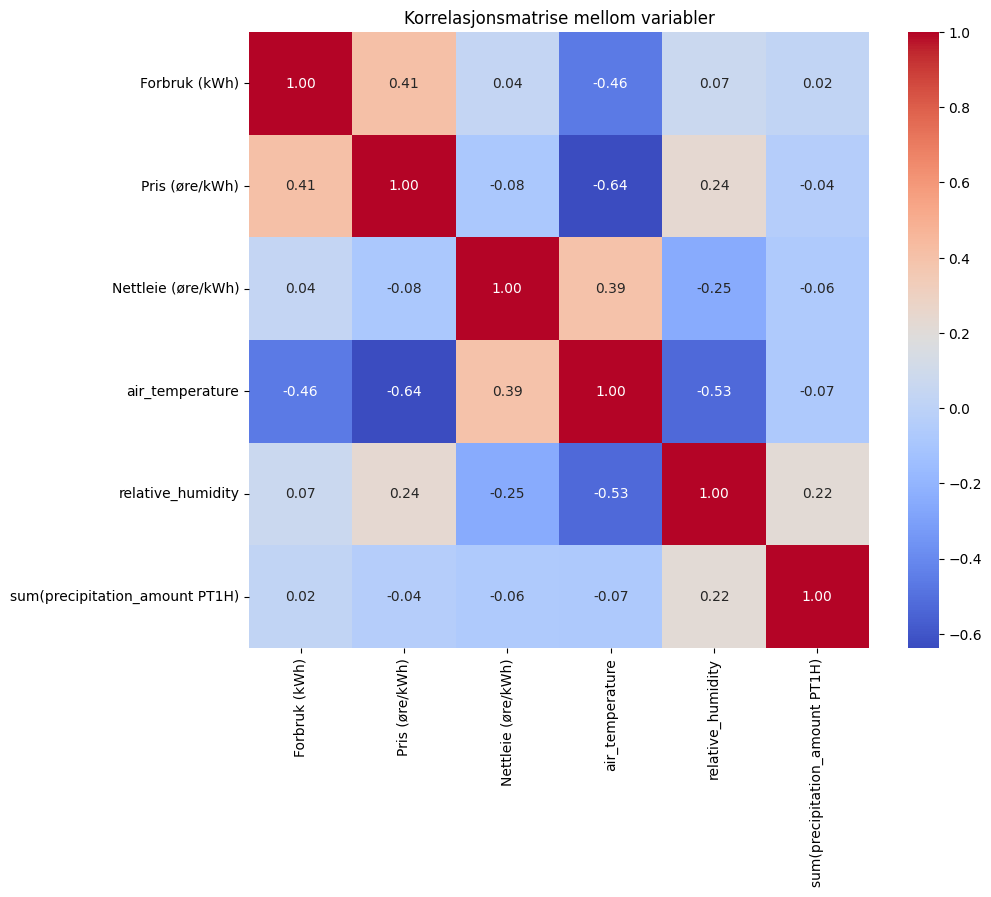

In [22]:
# Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_merged.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelasjonsmatrise mellom variabler")
plt.show()


In [23]:
print(df["Forbruk (kWh)"].describe())


count    744.000000
mean       2.022448
std        1.026119
min        0.384000
25%        1.287000
50%        1.817500
75%        2.526000
max        6.020000
Name: Forbruk (kWh), dtype: float64


 Vi har en gave i skjul for å finne strømtyven

In [24]:
# aggregere til daglig nivå
forbruk = df_merged["Forbruk (kWh)"].resample("D").sum()
df_daily = df_merged.resample("D").mean(numeric_only=True)
df_daily["Forbruk (kWh)"] = forbruk
df_daily


,Forbruk (kWh),Pris (øre/kWh),Nettleie (øre/kWh),air_temperature,relative_humidity,sum(precipitation_amount PT1H)
Tidspunkt,,,,,,
2025-08-01,3.576,21.877667,45.286667,20.979167,75.791667,0.000000
2025-08-02,3.630,16.449558,45.286667,19.787500,78.416667,0.000000
2025-08-03,3.105,11.334342,45.286667,20.654167,74.875000,0.087500
2025-08-04,3.705,17.420217,45.286667,18.833333,76.416667,0.020833
2025-08-05,3.520,6.222729,45.286667,17.820833,61.375000,0.266667
...,...,...,...,...,...,...
2025-12-27,35.189,61.974596,39.786667,3.808333,71.208333,0.195833
2025-12-28,35.412,66.453233,39.786667,4.287500,75.416667,0.287500
2025-12-29,38.840,65.083287,39.786667,-0.004167,81.333333,0.241667


In [25]:
df_daily["Forbruk (kWh)"].describe()


count    153.000000
mean      42.862575
std       17.987444
min        3.105000
25%       30.782000
50%       41.506000
75%       54.791000
max       95.044000
Name: Forbruk (kWh), dtype: float64

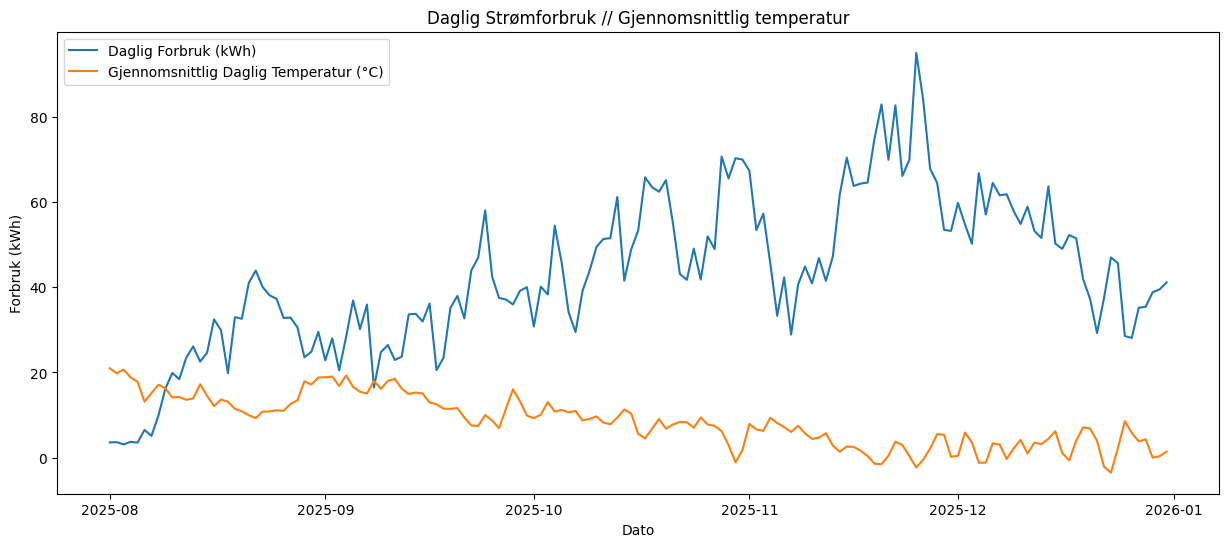

In [26]:
plt.figure(figsize=(15, 6))
plt.plot(df_daily.index, df_daily["Forbruk (kWh)"], label="Daglig Forbruk (kWh)")
plt.plot(df_daily.index, df_daily["air_temperature"], label="Gjennomsnittlig Daglig Temperatur (°C)")
plt.xlabel("Dato")
plt.ylabel("Forbruk (kWh)")
plt.title("Daglig Strømforbruk // Gjennomsnittlig temperatur")
plt.legend()
plt.show()


In [27]:
# Korrelasjon mellom daglig forbruk og temperatur
correlation, p_value = pearsonr(df_daily["Forbruk (kWh)"], df_daily["air_temperature"])
print(f"Korrelasjon mellom daglig forbruk og temperatur: {correlation:.2f} p= {p_value:.4f}")


Korrelasjon mellom daglig forbruk og temperatur: -0.79 p= 0.0000


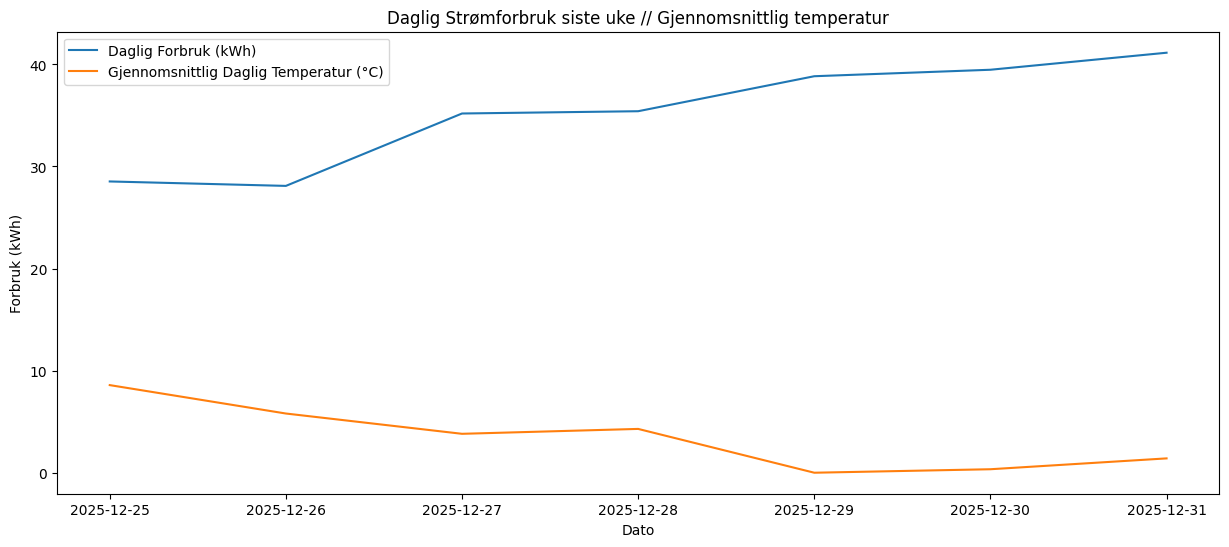

In [28]:
# siste uken ingen var hjemme
df_last_week = df_daily.last("7D")
plt.figure(figsize=(15, 6))
plt.plot(df_last_week.index, df_last_week["Forbruk (kWh)"], label="Daglig Forbruk (kWh)")
plt.plot(df_last_week.index, df_last_week["air_temperature"], label="Gjennomsnittlig Daglig Temperatur (°C)")
plt.xlabel("Dato")
plt.ylabel("Forbruk (kWh)")
plt.title("Daglig Strømforbruk siste uke // Gjennomsnittlig temperatur")
plt.legend()
plt.show()


In [29]:
# Korrelasjon mellom daglig forbruk og temperatur siste uke
correlation, p_value = pearsonr(df_last_week["Forbruk (kWh)"], df_last_week["air_temperature"])
print(f"Korrelasjon mellom daglig forbruk og temperatur siste uke: {correlation:.2f}")


Korrelasjon mellom daglig forbruk og temperatur siste uke: -0.91


In [30]:
df_daily["Forbruk (kWh)"].describe()


count    153.000000
mean      42.862575
std       17.987444
min        3.105000
25%       30.782000
50%       41.506000
75%       54.791000
max       95.044000
Name: Forbruk (kWh), dtype: float64

In [31]:
df_daily["air_temperature"].describe()


count    153.000000
mean       8.509071
std        5.936722
min       -3.541667
25%        3.808333
50%        8.291667
75%       13.037500
max       20.979167
Name: air_temperature, dtype: float64

Mean Squared Error: 80.63
R^2 Score: 0.68


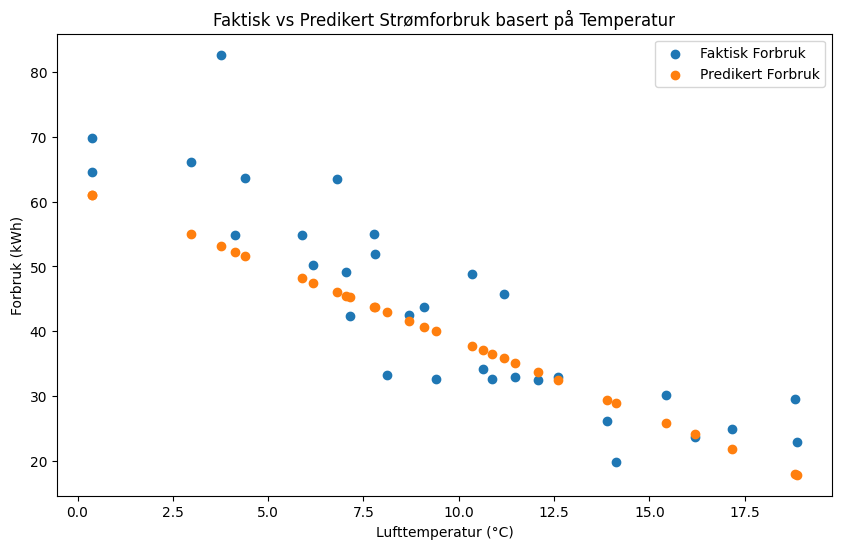

In [32]:
# Predikere forbruk gitt temperatur
X = df_daily[["air_temperature"]]
y = df_daily["Forbruk (kWh)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label="Faktisk Forbruk")
plt.scatter(X_test, y_pred, label="Predikert Forbruk")
plt.xlabel("Lufttemperatur (°C)")
plt.ylabel("Forbruk (kWh)")
plt.title("Faktisk vs Predikert Strømforbruk basert på Temperatur")
plt.legend()
plt.show()


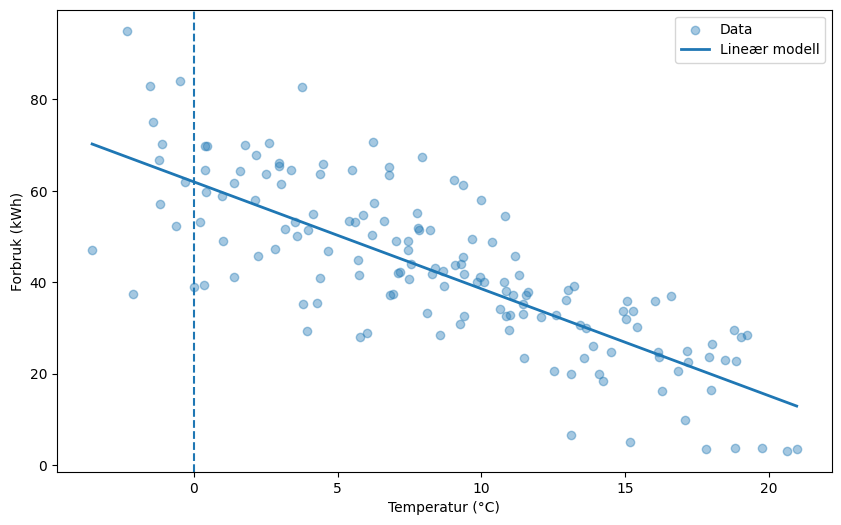

In [33]:
# Lag temperaturgrid
T = np.linspace(df_daily["air_temperature"].min(), df_daily["air_temperature"].max(), 100).reshape(-1, 1)
y_hat = model.predict(T)

plt.figure(figsize=(10, 6))
plt.scatter(df_daily["air_temperature"], df_daily["Forbruk (kWh)"], alpha=0.4, label="Data")
plt.plot(T, y_hat, linewidth=2, label="Lineær modell")
plt.axvline(0, linestyle="--")
plt.xlabel("Temperatur (°C)")
plt.ylabel("Forbruk (kWh)")
plt.legend()
plt.show()


In [34]:
# Forbruk på -17°C?
temp = -17
predicted_consumption = model.predict(np.array([[temp]]))
print(f"Predikert strømforbruk ved {temp}°C: {predicted_consumption[0]:.2f} kWh")
print(f"Ta hensyn til feilmargin på +-{sqrt(mse):.2f} kWh")


Predikert strømforbruk ved -17°C: 101.73 kWh
Ta hensyn til feilmargin på +-8.98 kWh


 På tide å se på ovenene

In [35]:
df_merged.index = pd.to_datetime(df_merged.index)
df_merged = df_merged.sort_index()

df_ovens = pd.read_excel("Data/Straum/ovndata.xlsx")
df_ovens.set_index("Dato", inplace=True)
df_ovens.head()


,Ovn 1 (stue),Ovn 2 (Endre),Ovn 3 (Otto),Ovn 4 (Tormund)
Dato,,,,
2025-11-26,1.99,2.47,NaN,NaN
2025-11-27,10.31,12.01,NaN,NaN
2025-11-28,10.29,11.48,NaN,NaN
2025-11-29,8.39,6.63,NaN,NaN
2025-11-30,10.47,9.45,7.12,NaN


In [36]:
# La oss estimere de andre ovnene
df_ovens["Ovn 3 (Otto)"] = df_ovens["Ovn 3 (Otto)"].fillna(df_ovens["Ovn 2 (Endre)"] * 0.9)
df_ovens["Ovn 4 (Tormund)"] = df_ovens["Ovn 4 (Tormund)"].fillna(df_ovens["Ovn 2 (Endre)"] * 1.2)


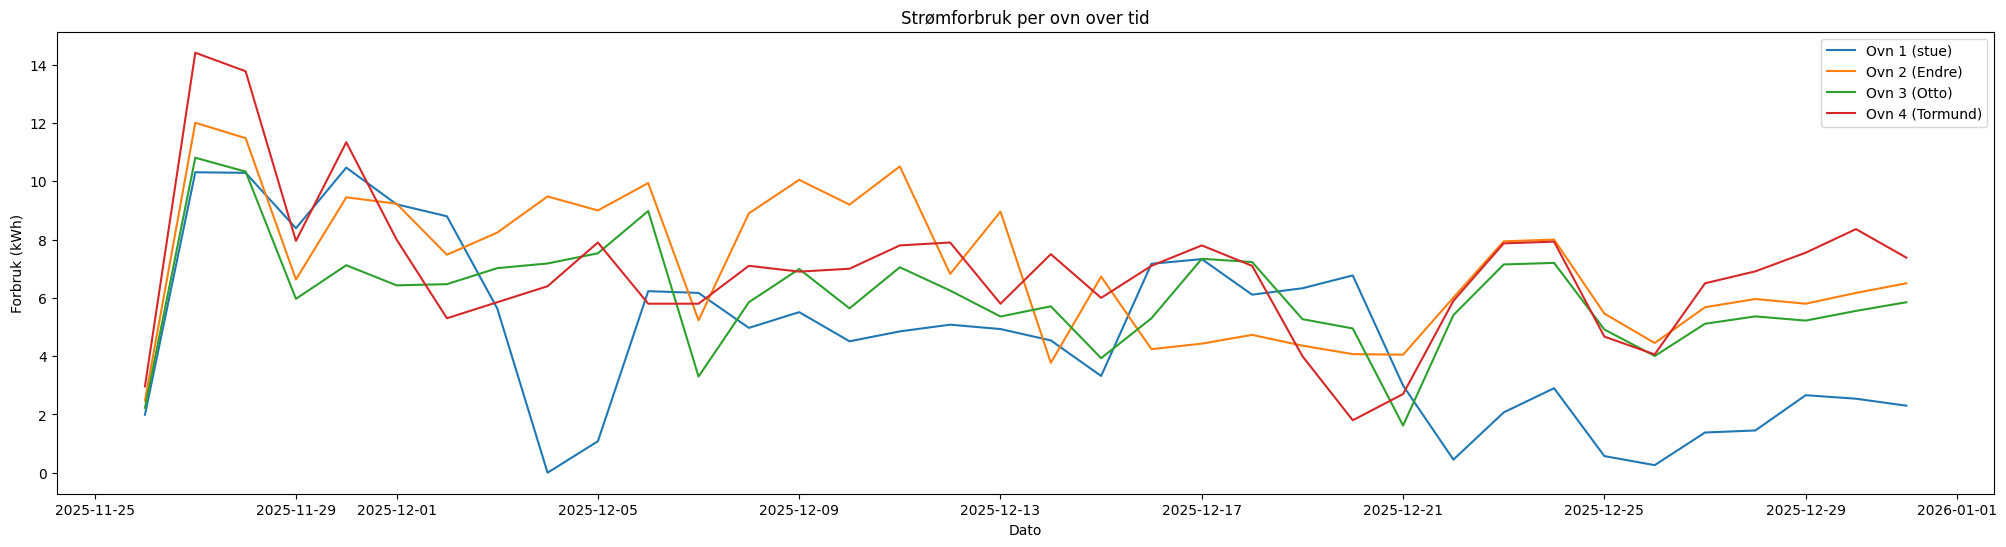

In [37]:
# Plott de forskjellige ovnene over tid
plt.figure(figsize=(25, 6))

df_ovn_int = df_ovens.copy()
for column in df_ovn_int.columns:
    plt.plot(df_ovn_int.index, df_ovn_int[column], label=column)

plt.xlabel("Dato")
plt.ylabel("Forbruk (kWh)")
plt.title("Strømforbruk per ovn over tid")
plt.legend()
plt.show()


 Siden Otto koblet ut måleren før han dro, så har vi egentlig ikke data fra ovnen hans.

 Men vi kan anta at den brukte en del, så vi gir en konservativ gjetning på at den brukte tilsvarende 12 kwh per dag

 (1.2 kW ovn på 20 timer) - dekker sannsynligvis alle scenarioer

In [38]:
last_7_days = df_ovens.index >= (df_ovens.index.max() - pd.Timedelta(days=7))
df_ovens.loc[last_7_days, "Ovn 3 (Otto)"] = 1.5 * df_ovens.loc[last_7_days, "Ovn 2 (Endre)"]

df_ovens["Sum Ovn (kWh)"] = df_ovens.sum(axis=1, skipna=True)
df_ovens.tail()


,Ovn 1 (stue),Ovn 2 (Endre),Ovn 3 (Otto),Ovn 4 (Tormund),Sum Ovn (kWh)
Dato,,,,,
2025-12-27,1.38,5.68,8.520,6.50,22.080
2025-12-28,1.45,5.96,8.940,6.91,23.260
2025-12-29,2.66,5.80,8.700,7.55,24.710
2025-12-30,2.54,6.17,9.255,8.36,26.325
2025-12-31,2.30,6.50,9.750,7.38,25.930


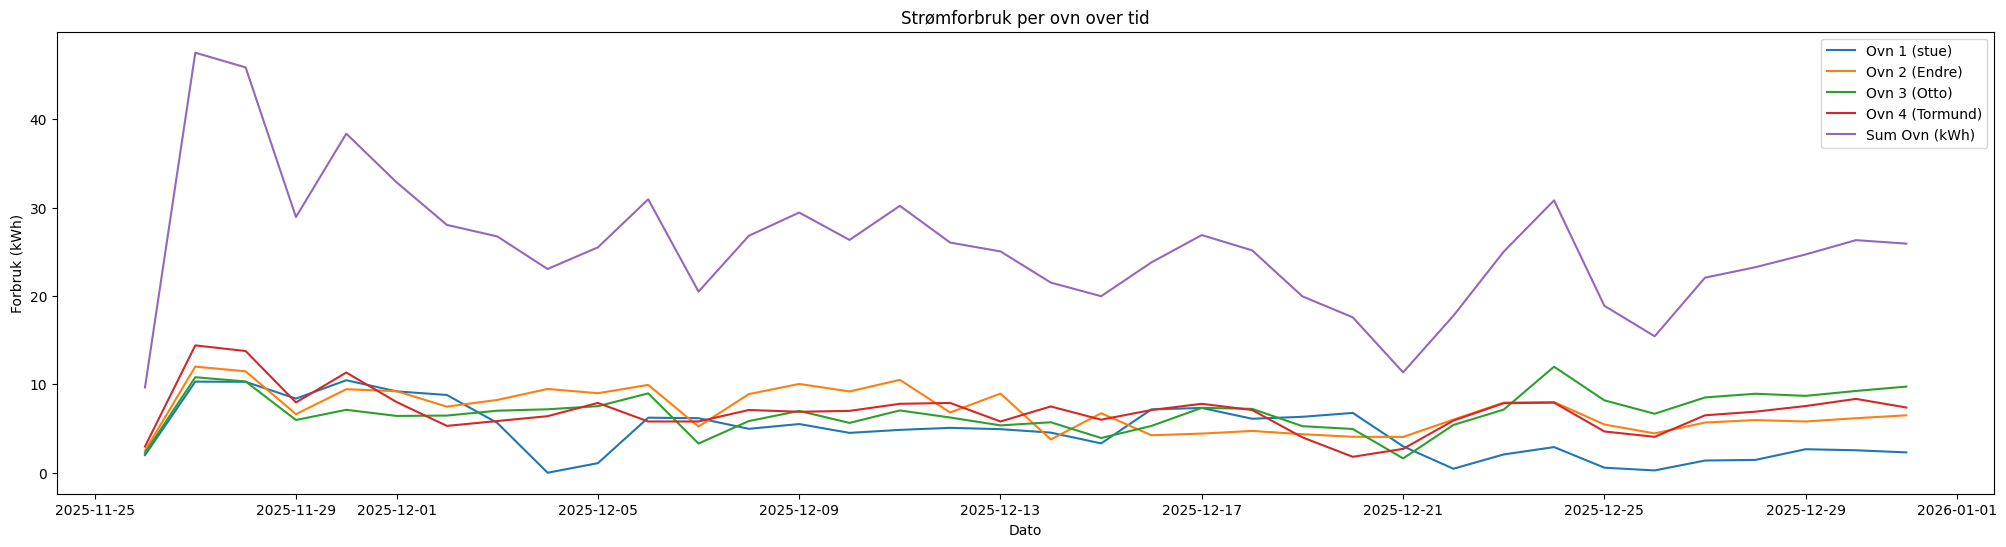

In [39]:
# Plott de forskjellige ovnene over tid
plt.figure(figsize=(25, 6))

df_ovn_int = df_ovens.copy()
for column in df_ovn_int.columns:
    plt.plot(df_ovn_int.index, df_ovn_int[column], label=column)

plt.xlabel("Dato")
plt.ylabel("Forbruk (kWh)")
plt.title("Strømforbruk per ovn over tid")
plt.legend()
plt.show()


In [40]:
df_anal = df_daily.merge(
    df_ovens,
    left_index=True,
    right_index=True,
    how="inner",  # kun dager vi faktisk har ovnsdata
)
df_anal.head()

# I python kan man skrive ting som dette:
# df_anal.head().cummax()
# som betyr "kumulativ maksimum", altså den høyeste verdien så langt i datasettet

# første dagen er tull så vi dropper den
df_anal = df_anal.iloc[1:]

# dropper også nettleie
df_anal = df_anal.drop(columns=["Nettleie (øre/kWh)"])
df_anal.head()


,Forbruk (kWh),Pris (øre/kWh),air_temperature,relative_humidity,sum(precipitation_amount PT1H),Ovn 1 (stue),Ovn 2 (Endre),Ovn 3 (Otto),Ovn 4 (Tormund),Sum Ovn (kWh)
2025-11-27,67.768,58.384737,2.145833,79.291667,0.112500,10.31,12.01,10.809,14.412,47.541
2025-11-28,64.508,58.260267,5.495833,72.708333,0.079167,10.29,11.48,10.332,13.776,45.878
2025-11-29,53.457,59.244379,5.387500,71.083333,0.304167,8.39,6.63,5.967,7.956,28.943
2025-11-30,53.216,78.358550,0.200000,85.583333,0.070833,10.47,9.45,7.120,11.340,38.380
2025-12-01,59.797,96.922821,0.437500,86.708333,0.000000,9.21,9.23,6.430,8.000,32.870


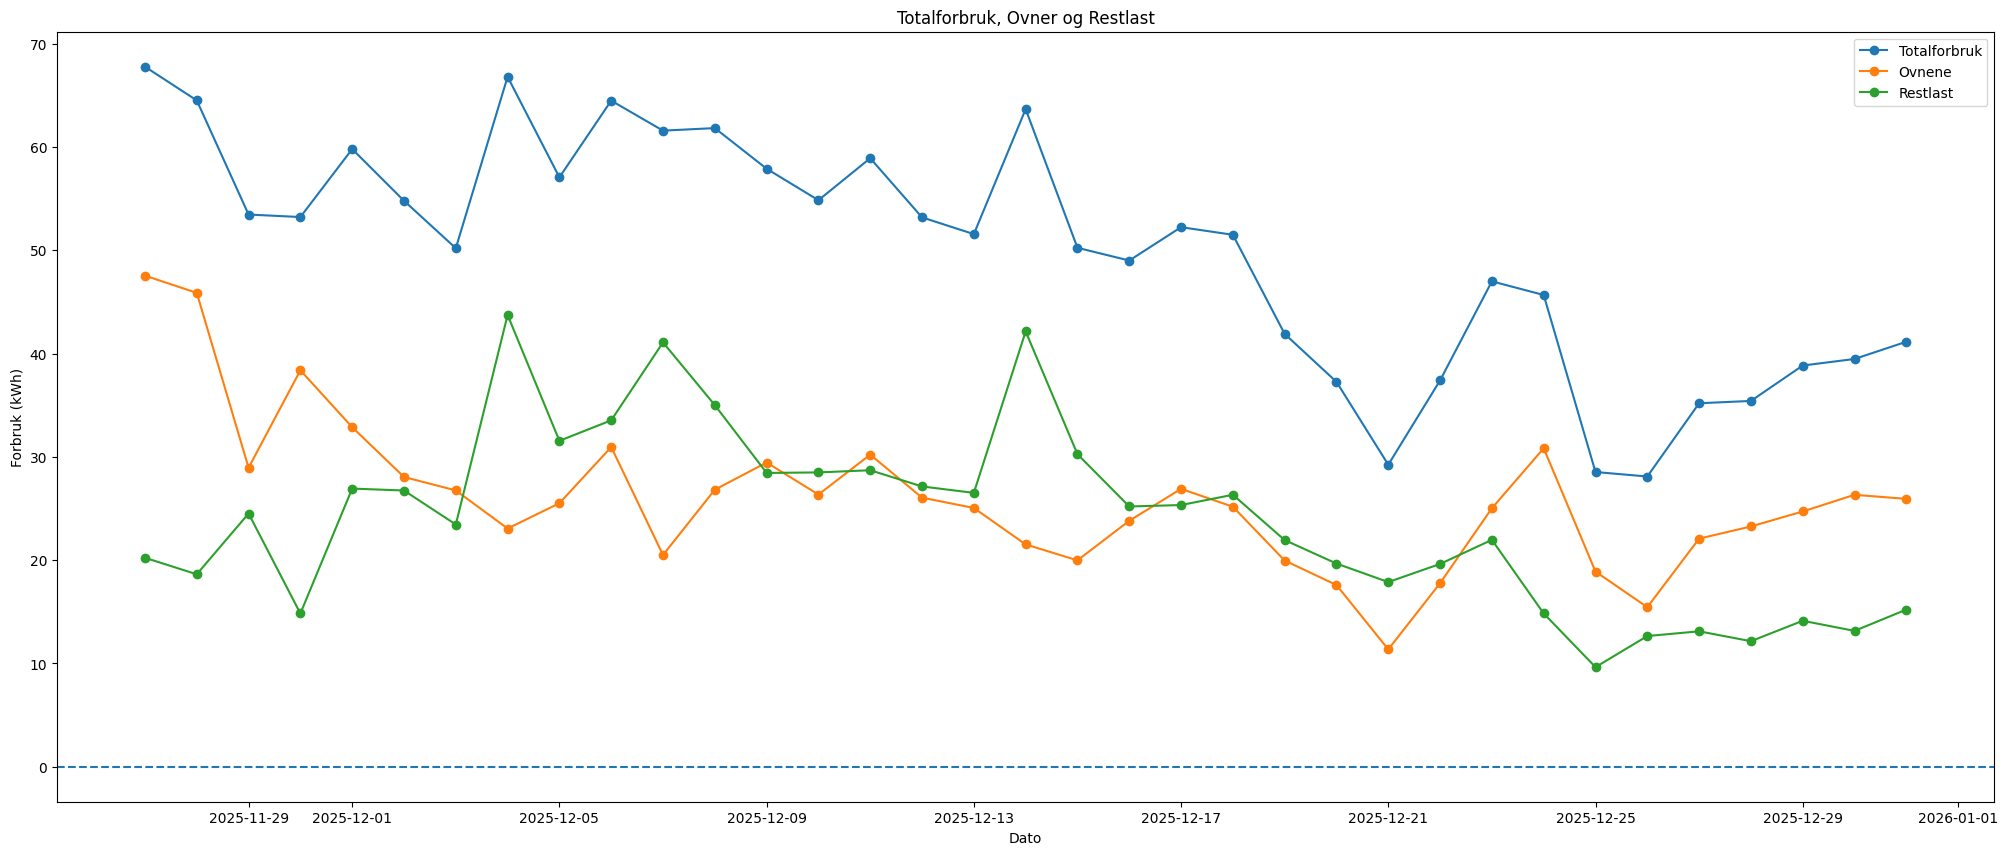

In [41]:
# Finner reststrøm
df_anal["Restlast (kWh)"] = df_anal["Forbruk (kWh)"] - df_anal["Sum Ovn (kWh)"]

plt.figure(figsize=(25, 10))
plt.plot(df_anal.index, df_anal["Forbruk (kWh)"], label="Totalforbruk", marker="o")
plt.plot(df_anal.index, df_anal["Sum Ovn (kWh)"], label="Ovnene", marker="o")
plt.plot(df_anal.index, df_anal["Restlast (kWh)"], label="Restlast", marker="o")
plt.axhline(y=0, linestyle="--")
plt.xlabel("Dato")
plt.ylabel("Forbruk (kWh)")
plt.title("Totalforbruk, Ovner og Restlast")
plt.legend()
plt.show()


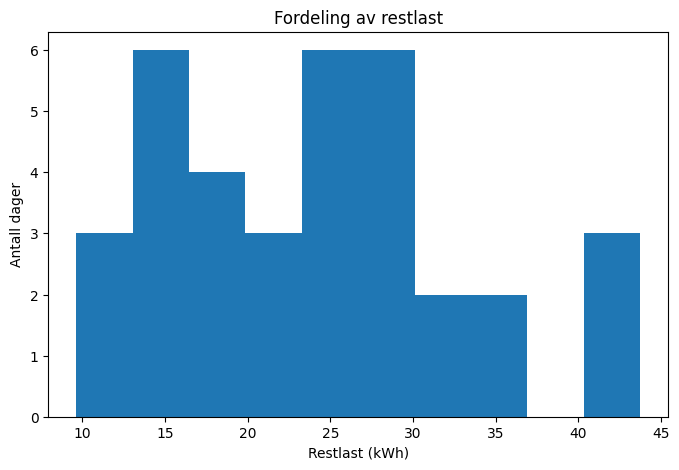

In [42]:
df_anal["Restlast (kWh)"].plot(kind="hist", bins=10, figsize=(8, 5))
plt.xlabel("Restlast (kWh)")
plt.ylabel("Antall dager")
plt.title("Fordeling av restlast")
plt.show()


In [43]:
df_anal.head()


,Forbruk (kWh),Pris (øre/kWh),air_temperature,relative_humidity,sum(precipitation_amount PT1H),Ovn 1 (stue),Ovn 2 (Endre),Ovn 3 (Otto),Ovn 4 (Tormund),Sum Ovn (kWh),Restlast (kWh)
2025-11-27,67.768,58.384737,2.145833,79.291667,0.112500,10.31,12.01,10.809,14.412,47.541,20.227
2025-11-28,64.508,58.260267,5.495833,72.708333,0.079167,10.29,11.48,10.332,13.776,45.878,18.630
2025-11-29,53.457,59.244379,5.387500,71.083333,0.304167,8.39,6.63,5.967,7.956,28.943,24.514
2025-11-30,53.216,78.358550,0.200000,85.583333,0.070833,10.47,9.45,7.120,11.340,38.380,14.836
2025-12-01,59.797,96.922821,0.437500,86.708333,0.000000,9.21,9.23,6.430,8.000,32.870,26.927


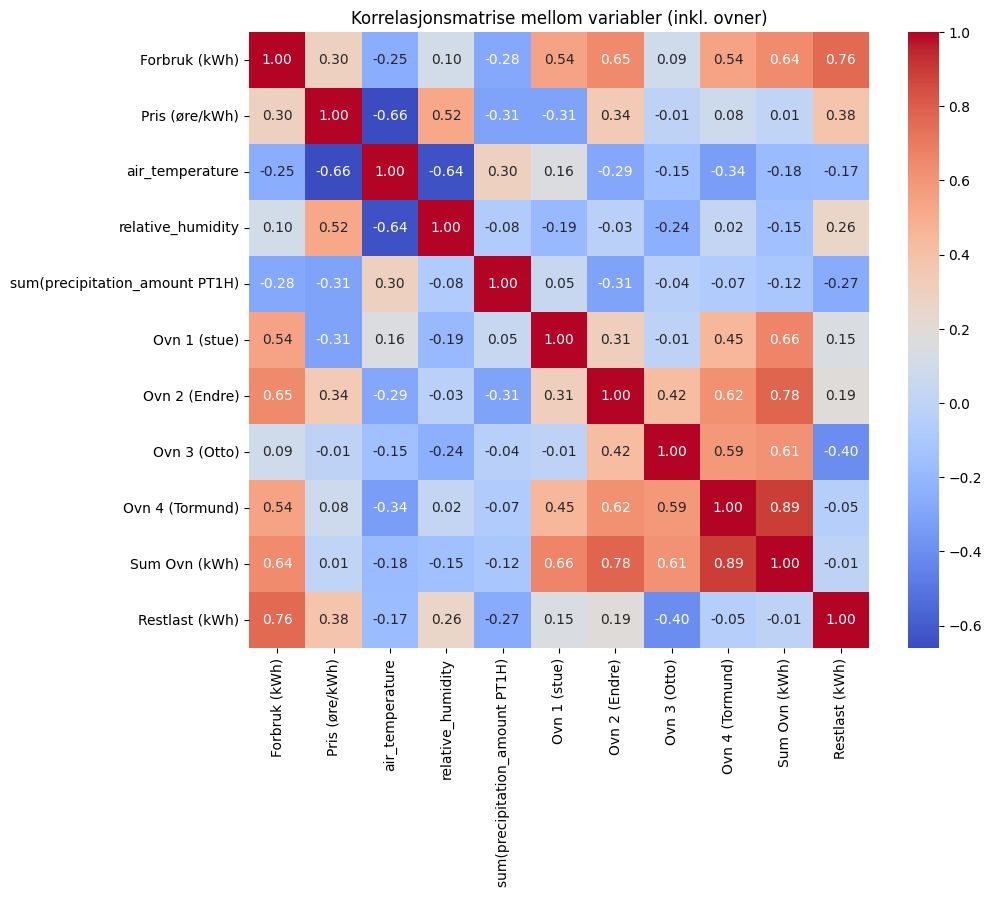

In [44]:
# heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_anal.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelasjonsmatrise mellom variabler (inkl. ovner)")
plt.show()


 korrelasjon != kasualitet

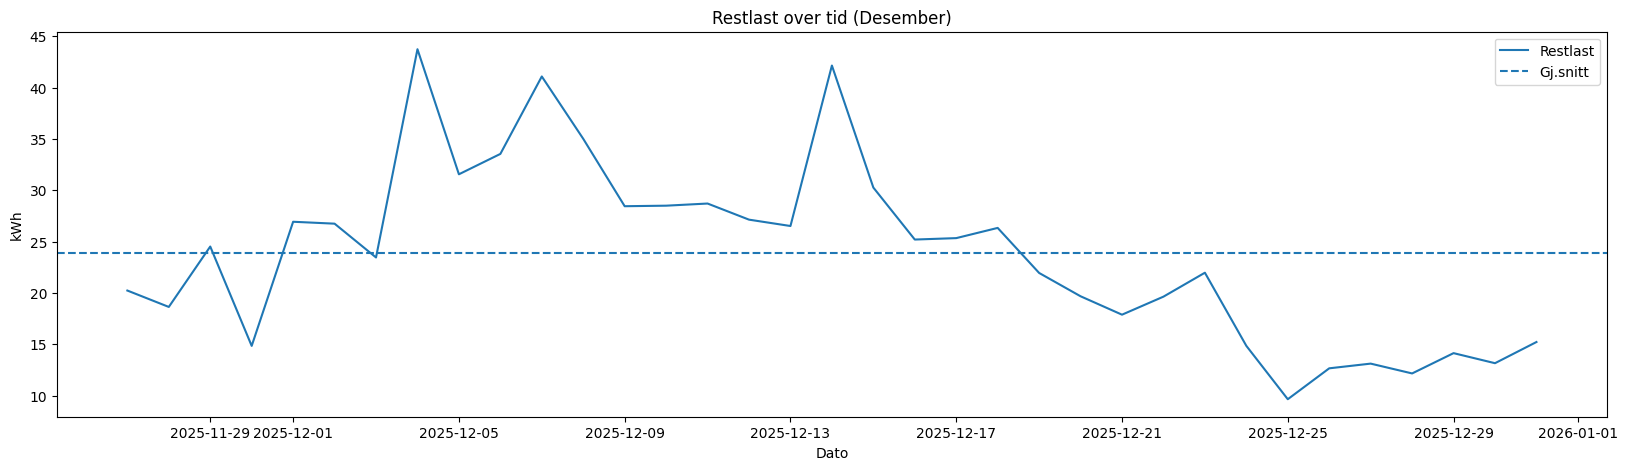

In [45]:
plt.figure(figsize=(20, 5))
plt.plot(df_anal.index, df_anal["Restlast (kWh)"], label="Restlast")
plt.axhline(df_anal["Restlast (kWh)"].mean(), linestyle="--", label="Gj.snitt")
plt.xlabel("Dato")
plt.ylabel("kWh")
plt.title("Restlast over tid (Desember)")
plt.legend()
plt.show()


 Hvor går resten av strømmen?

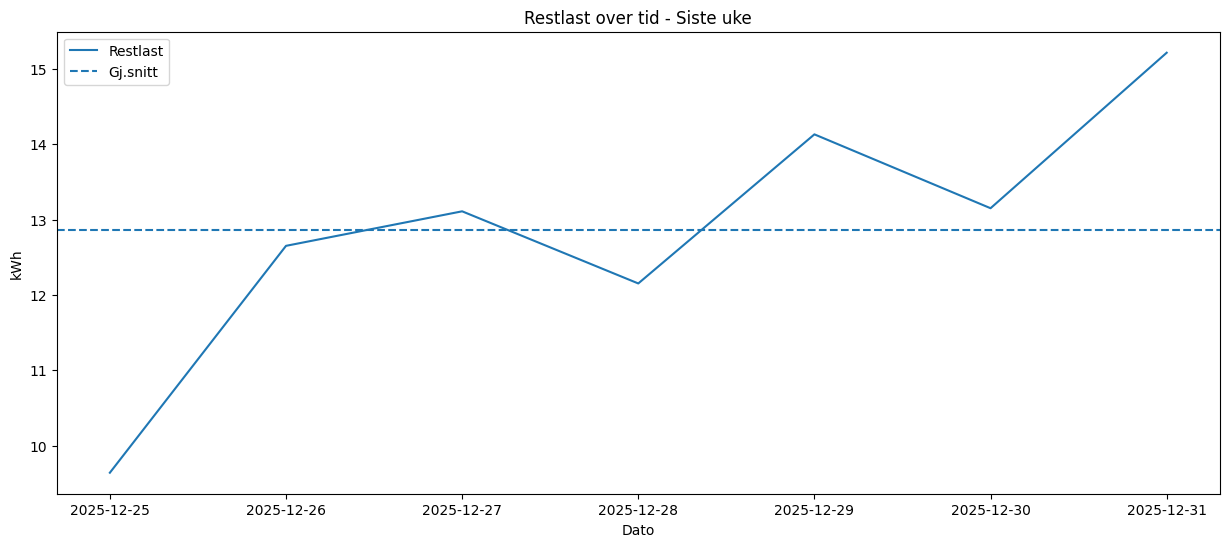

In [46]:
# ser mer på uken ingen var hjemme
df_last_week_anal = df_anal.last("7D")

plt.figure(figsize=(15, 6))
plt.plot(df_last_week_anal.index, df_last_week_anal["Restlast (kWh)"], label="Restlast")
plt.axhline(df_last_week_anal["Restlast (kWh)"].mean(), linestyle="--", label="Gj.snitt")
plt.xlabel("Dato")
plt.ylabel("kWh")
plt.title("Restlast over tid - Siste uke")
plt.legend()
plt.show()


 17 kwh per dag i restlast ved grov overslag på forbruket til otto sin ovn ... Hva skjer her?

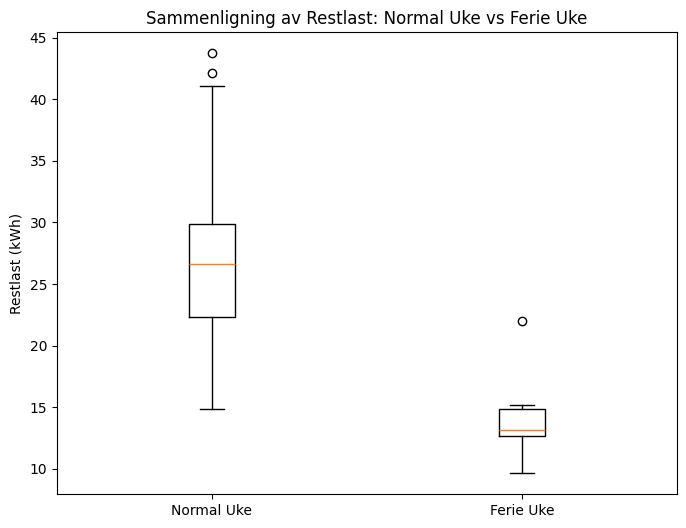

In [47]:
# Boxplot av restlast vs normal uke
plt.figure(figsize=(8, 6))
ferie = df_anal.last("9D")
normal = df_anal.drop(ferie.index)

data_to_plot = [normal["Restlast (kWh)"], ferie["Restlast (kWh)"]]
plt.boxplot(data_to_plot, labels=["Normal Uke", "Ferie Uke"])
plt.ylabel("Restlast (kWh)")
plt.title("Sammenligning av Restlast: Normal Uke vs Ferie Uke")
plt.show()


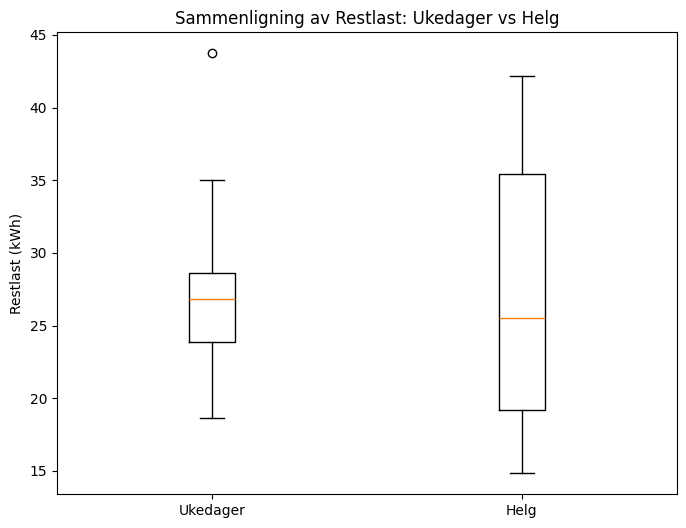

In [48]:
# Boxplot ukedager vs helg
plt.figure(figsize=(8, 6))
data_to_plot = [
    normal[normal.index.dayofweek < 5]["Restlast (kWh)"],   # Ukedager
    normal[normal.index.dayofweek >= 5]["Restlast (kWh)"],  # Helg
]
plt.boxplot(data_to_plot, labels=["Ukedager", "Helg"])
plt.ylabel("Restlast (kWh)")
plt.title("Sammenligning av Restlast: Ukedager vs Helg")
plt.show()


In [49]:
normal.head()


,Forbruk (kWh),Pris (øre/kWh),air_temperature,relative_humidity,sum(precipitation_amount PT1H),Ovn 1 (stue),Ovn 2 (Endre),Ovn 3 (Otto),Ovn 4 (Tormund),Sum Ovn (kWh),Restlast (kWh)
2025-11-27,67.768,58.384737,2.145833,79.291667,0.112500,10.31,12.01,10.809,14.412,47.541,20.227
2025-11-28,64.508,58.260267,5.495833,72.708333,0.079167,10.29,11.48,10.332,13.776,45.878,18.630
2025-11-29,53.457,59.244379,5.387500,71.083333,0.304167,8.39,6.63,5.967,7.956,28.943,24.514
2025-11-30,53.216,78.358550,0.200000,85.583333,0.070833,10.47,9.45,7.120,11.340,38.380,14.836
2025-12-01,59.797,96.922821,0.437500,86.708333,0.000000,9.21,9.23,6.430,8.000,32.870,26.927


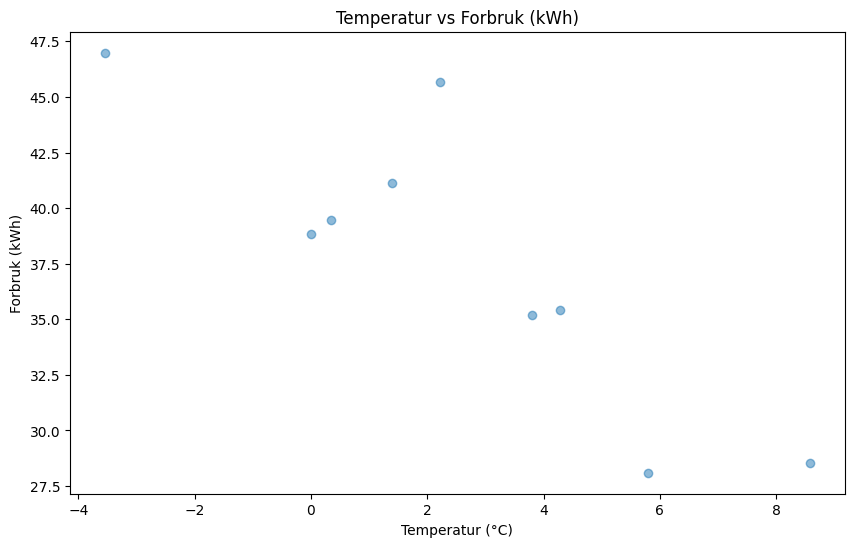

Korrelasjon mellom temperatur og forbruk: -0.86, p-verdi: 0.0027


In [50]:
# Temperatur vs forbruk
plt.figure(figsize=(10, 6))
plt.scatter(ferie["air_temperature"], ferie["Forbruk (kWh)"], alpha=0.5)
plt.title("Temperatur vs Forbruk (kWh)")
plt.xlabel("Temperatur (°C)")
plt.ylabel("Forbruk (kWh)")
plt.show()

ptest = pearsonr(ferie["air_temperature"], ferie["Forbruk (kWh)"])
print(f"Korrelasjon mellom temperatur og forbruk: {ptest[0]:.2f}, p-verdi: {ptest[1]:.4f}")


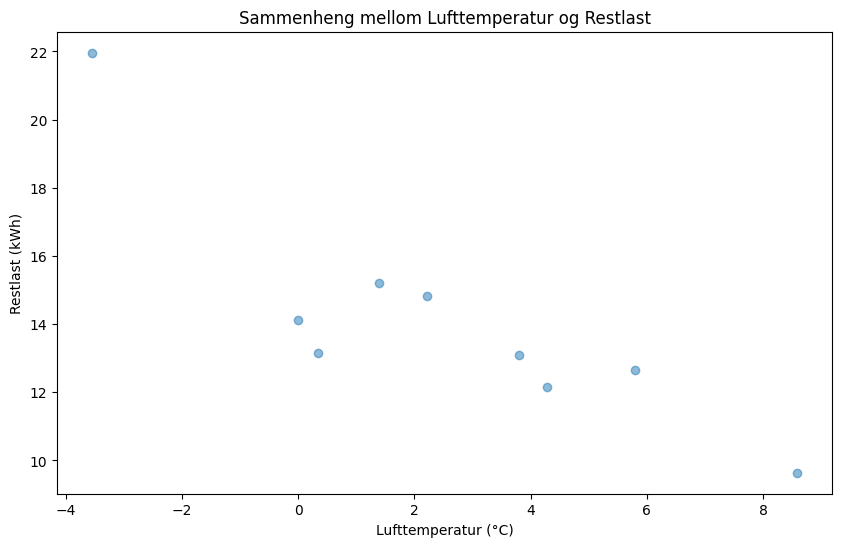

Korrelasjon mellom Lufttemperatur og Restlast: -0.87


In [51]:
# Temperatur vs Restlast
plt.figure(figsize=(10, 6))
plt.scatter(ferie["air_temperature"], ferie["Restlast (kWh)"], alpha=0.5)
plt.xlabel("Lufttemperatur (°C)")
plt.ylabel("Restlast (kWh)")
plt.title("Sammenheng mellom Lufttemperatur og Restlast")
plt.show()

corr = ferie[["air_temperature", "Restlast (kWh)"]].corr().iloc[0, 1]
print(f"Korrelasjon mellom Lufttemperatur og Restlast: {corr:.2f}")


 Svak sammenheng mellom temperatur og restlast, men ikke neglisjerbar.

 Restlast er mest sannsynlig ikke temperaturavhengig (?).

In [52]:
r, p = pearsonr(normal["air_temperature"], normal["Restlast (kWh)"])
print(f"Pearson r = {r:.3f}, p-verdi = {p:.3e}")


Pearson r = -0.171, p-verdi = 4.046e-01


In [53]:
from scipy.stats import spearmanr
rho, p = spearmanr(normal["air_temperature"], normal["Restlast (kWh)"])
print(f"Spearman rho = {rho:.3f}, p-verdi = {p:.3e}")


Spearman rho = -0.193, p-verdi = 3.444e-01


 Forbruksanalyse ..

In [54]:
df_forbruk = df_merged.copy()

# Hjelpevariabler
df_forbruk["Hour"] = df_forbruk.index.hour
df_forbruk["Day"] = df_forbruk.index.dayofweek
df_forbruk["Month"] = df_forbruk.index.month
df_forbruk["isHelg"] = df_forbruk["Day"] >= 5

df_forbruk.head()


,Forbruk (kWh),Pris (øre/kWh),Nettleie (øre/kWh),air_temperature,relative_humidity,sum(precipitation_amount PT1H),Hour,Day,Month,isHelg
Tidspunkt,,,,,,,,,,
2025-08-01 00:00:00,0.083,19.4875,36.04,16.9,95.0,0.0,0,4,8,False
2025-08-01 01:00:00,0.083,19.1038,36.04,16.6,96.0,0.0,1,4,8,False
2025-08-01 02:00:00,0.082,18.1887,36.04,16.3,97.0,0.0,2,4,8,False
2025-08-01 03:00:00,0.084,16.4350,36.04,16.6,98.0,0.0,3,4,8,False
2025-08-01 04:00:00,0.082,16.4638,36.04,16.9,96.0,0.0,4,4,8,False


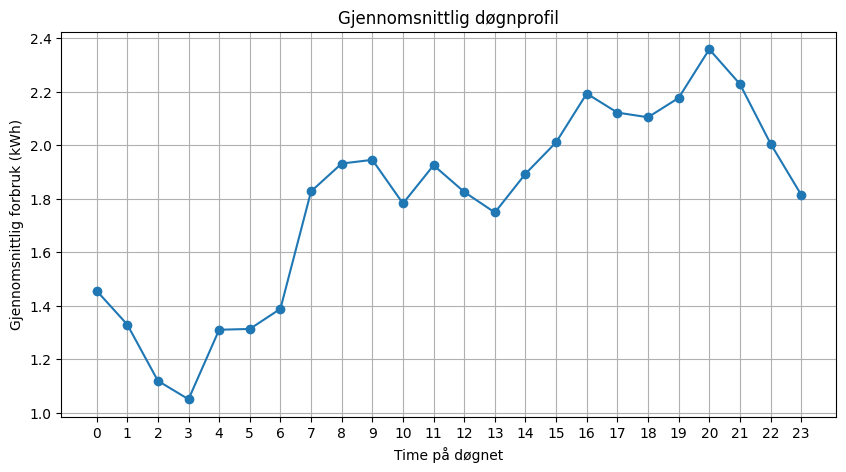

In [55]:
profile = df_forbruk.groupby("Hour")["Forbruk (kWh)"].mean()

plt.figure(figsize=(10, 5))
plt.plot(profile, marker="o")
plt.xticks(range(0, 24))
plt.xlabel("Time på døgnet")
plt.ylabel("Gjennomsnittlig forbruk (kWh)")
plt.title("Gjennomsnittlig døgnprofil")
plt.grid(True)
plt.show()


 Innsikt: Topp og bunnpunkt -> når vi bruker mest og minst.

 Tolkning: gjennomsnittlig strømprofil gitt klokkeslett

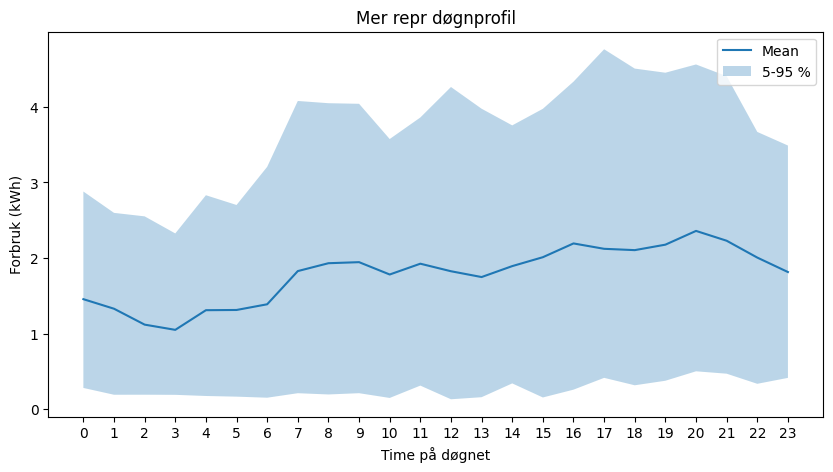

In [56]:
hourly = df_forbruk.groupby("Hour")["Forbruk (kWh)"]
mean = hourly.mean()
q10 = hourly.quantile(0.05)
q90 = hourly.quantile(0.95)

plt.figure(figsize=(10, 5))
plt.plot(mean, label="Mean")
plt.fill_between(mean.index, q10, q90, alpha=0.3, label="5-95 %")
plt.xticks(range(0, 24))
plt.legend()
plt.xlabel("Time på døgnet")
plt.ylabel("Forbruk (kWh)")
plt.title("Mer repr døgnprofil")
plt.show()


In [57]:
theoretical_peak = mean.max()
theoretical_offpeak = mean.min()
print(f"Theoretical Peak Load: {theoretical_peak:.2f} kWh")
print(f"Theoretical Off-Peak Load: {theoretical_offpeak:.2f} kWh")

actual_peak = df_forbruk["Forbruk (kWh)"].max()
actual_offpeak = df_forbruk["Forbruk (kWh)"].min()
print(f"Actual Peak Load: {actual_peak:.2f} kWh")
print(f"Actual Off-Peak Load: {actual_offpeak:.2f} kWh")


Theoretical Peak Load: 2.36 kWh
Theoretical Off-Peak Load: 1.05 kWh
Actual Peak Load: 7.75 kWh
Actual Off-Peak Load: 0.07 kWh


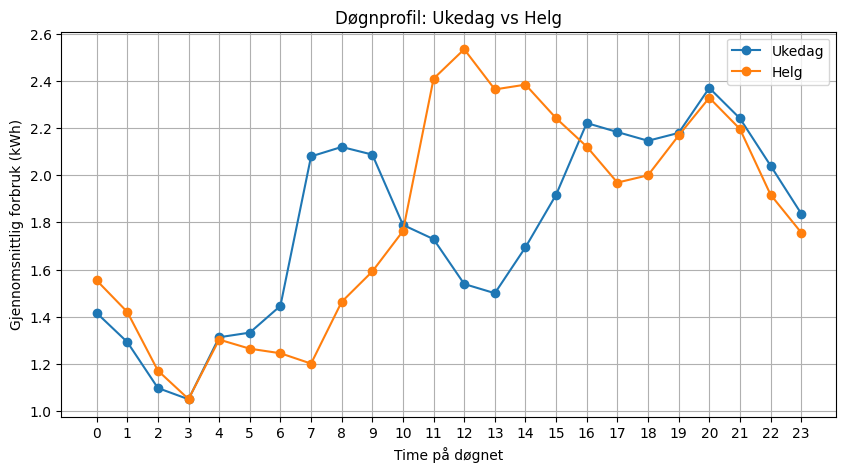

In [58]:
# Helg vs ukedag
week = df_forbruk[~df_forbruk["isHelg"]].groupby("Hour")["Forbruk (kWh)"].mean()
weekend = df_forbruk[df_forbruk["isHelg"]].groupby("Hour")["Forbruk (kWh)"].mean()

plt.figure(figsize=(10, 5))
plt.plot(week, label="Ukedag", marker="o")
plt.plot(weekend, label="Helg", marker="o")
plt.xticks(range(0, 24))
plt.xlabel("Time på døgnet")
plt.ylabel("Gjennomsnittlig forbruk (kWh)")
plt.title("Døgnprofil: Ukedag vs Helg")
plt.legend()
plt.grid(True)
plt.show()


 Innsikt:

 Her kan vi se effekten av en dusj og en varm ovn på morgenen.

 Deretter drar vi på skolen og kommer hjem på ettermiddagen/kvelden for å lage mat.



 I helgene ser vi et jevnere forbruk gjennom dagen med en senere topp.



 For begge gjelder matlaging hovedsakelig på ettermiddagen.

In [59]:
# Minimum last
night_hours = df_forbruk[(df_forbruk.index.hour >= 2) & (df_forbruk.index.hour <= 4)]
min_night_load = night_hours["Forbruk (kWh)"]
min_night_load.describe()


count    460.000000
mean       1.159280
std        0.736053
min        0.082000
25%        0.601500
50%        1.068000
75%        1.564000
max        3.610000
Name: Forbruk (kWh), dtype: float64

In [60]:
min_night_load.quantile(0.1)


0.27160000000000006

 Innsikt:

 Gjennomsnittlig minimum last er rundt 1.15 (kWh/h), altså ca 27.6 kWh/døgn.

 Chat sa at man burde se på nedre 10% for baselast.

In [61]:
base = df_forbruk.groupby("Hour")["Forbruk (kWh)"].quantile(0.1)
df_forbruk["BaseLoad"] = df_forbruk["Hour"].map(base)
df_forbruk["VariableLoad"] = df_forbruk["Forbruk (kWh)"] - df_forbruk["BaseLoad"]


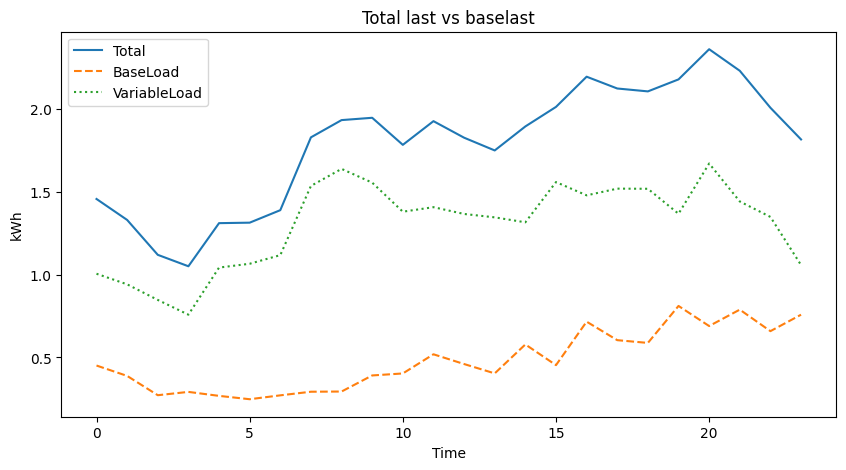

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(df_forbruk.groupby("Hour")["Forbruk (kWh)"].mean(), label="Total")
plt.plot(base, label="BaseLoad", linestyle="--")
plt.plot(df_forbruk.groupby("Hour")["VariableLoad"].mean(), label="VariableLoad", linestyle=":")
plt.legend()
plt.xlabel("Time")
plt.ylabel("kWh")
plt.title("Total last vs baselast")
plt.show()


 Den blåe er total last, den oransje er baselast (10% kvantil), og den grønne er variabel last.

 Baselast ser temperaturavhengig ut -> tyder på varmelast.

In [63]:
share = df_forbruk["BaseLoad"].sum() / df_forbruk["Forbruk (kWh)"].sum()
print(f"Andel baselast: {share:.2%}")


Andel baselast: 27.06%


In [64]:
min_night_load


Tidspunkt
2025-08-01 02:00:00    0.082
2025-08-01 03:00:00    0.084
2025-08-01 04:00:00    0.082
2025-08-02 02:00:00    0.084
2025-08-02 03:00:00    0.085
                       ...  
2025-12-30 03:00:00    1.362
2025-12-30 04:00:00    2.348
2025-12-31 02:00:00    1.604
2025-12-31 03:00:00    1.288
2025-12-31 04:00:00    2.260
Name: Forbruk (kWh), Length: 460, dtype: float64

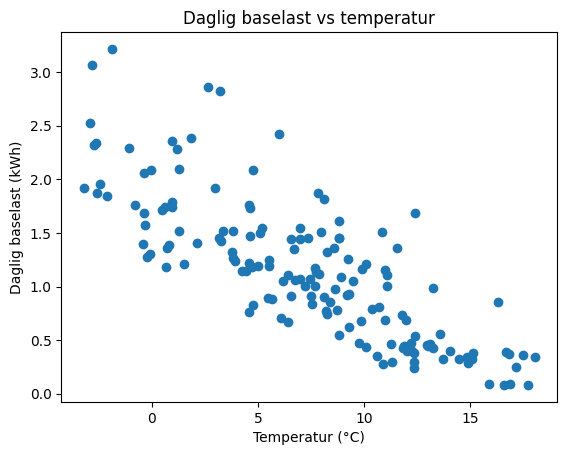

Pearson r = -0.806, p-verdi = 2.961e-36


In [65]:
# Er baselast temperaturavhengig?
night = df_forbruk.between_time("02:00", "04:00")
daily_base = night.groupby(night.index.date)["Forbruk (kWh)"].mean()
daily_temp = night.groupby(night.index.date)["air_temperature"].mean()

plt.scatter(daily_temp, daily_base)
plt.xlabel("Temperatur (°C)")
plt.ylabel("Daglig baselast (kWh)")
plt.title("Daglig baselast vs temperatur")
plt.show()

r, p = pearsonr(daily_temp, daily_base)
print(f"Pearson r = {r:.3f}, p-verdi = {p:.3e}")


 Her forkastes nullhypotesen direkte -> baselast er temperaturavhengig.

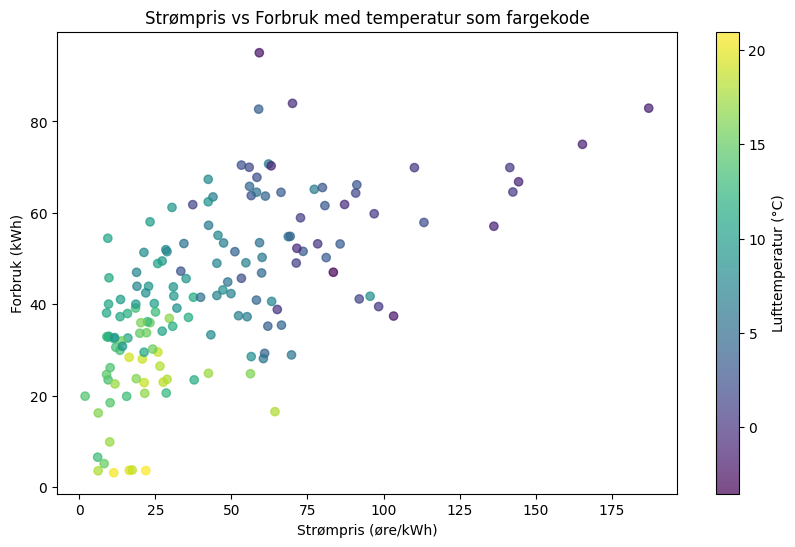

In [66]:
# Prissensitivitet - er vi bevisste på prisendringer?
plt.figure(figsize=(10, 6))
plt.scatter(
    df_daily["Pris (øre/kWh)"],
    df_daily["Forbruk (kWh)"],
    c=df_daily["air_temperature"],
    cmap="viridis",
    alpha=0.7,
)
plt.colorbar(label="Lufttemperatur (°C)")
plt.xlabel("Strømpris (øre/kWh)")
plt.ylabel("Forbruk (kWh)")
plt.title("Strømpris vs Forbruk med temperatur som fargekode")
plt.show()


In [67]:
from pingouin import partial_corr

partial_corr(
    data=df_daily,
    x="Pris (øre/kWh)",
    y="Forbruk (kWh)",
    covar="air_temperature",
    method="pearson",
)


,n,r,CI95%,p-val
pearson,153,0.039199,"[-0.12, 0.2]",0.631603


 Avanserte verktøy

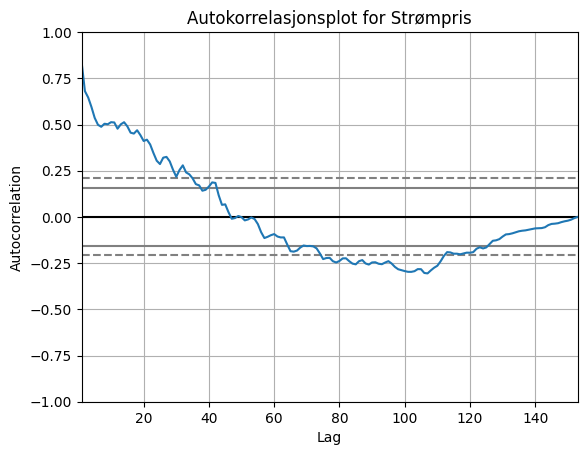

In [68]:
# pris autokorrelasjon
pd.plotting.autocorrelation_plot(df_daily["Pris (øre/kWh)"])
plt.title("Autokorrelasjonsplot for Strømpris")
plt.show()


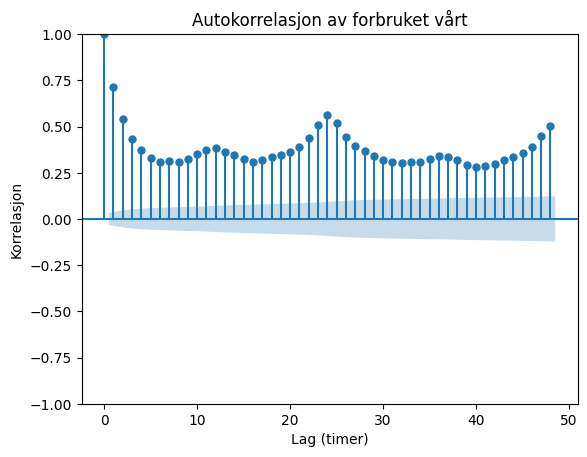

In [69]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_forbruk["Forbruk (kWh)"], lags=48)
plt.title("Autokorrelasjon av forbruket vårt")
plt.xlabel("Lag (timer)")
plt.ylabel("Korrelasjon")
plt.show()


 Innsikt:

 Vi er vanedyr: sterk autokorrelasjon time-til-time og dag-til-dag.

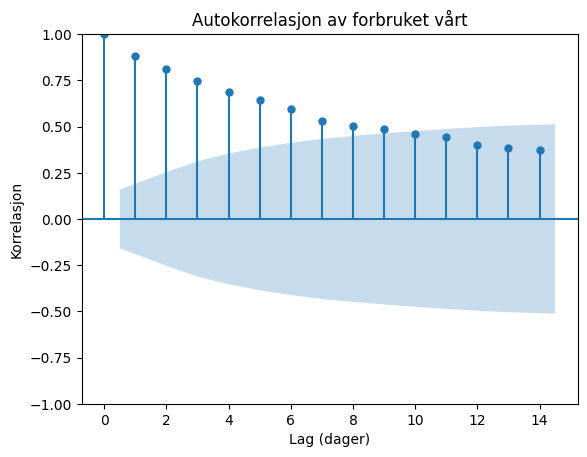

In [70]:
plot_acf(df_daily["Forbruk (kWh)"], lags=14)
plt.title("Autokorrelasjon av forbruket vårt")
plt.xlabel("Lag (dager)")
plt.ylabel("Korrelasjon")
plt.show()


<Figure size 1000x500 with 0 Axes>

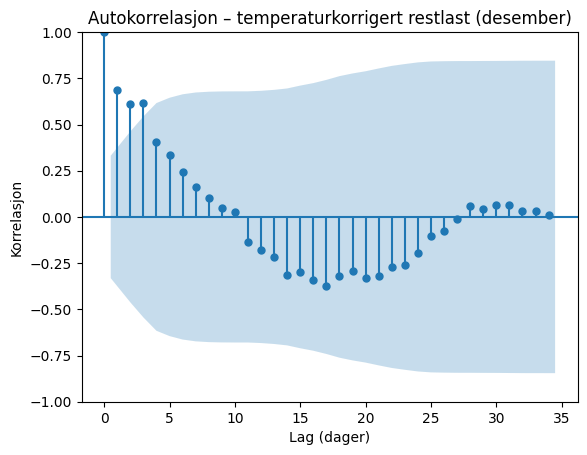

In [71]:
plt.figure(figsize=(10, 5))
plot_acf(df_anal["Restlast (kWh)"], lags=34)
plt.title("Autokorrelasjon – temperaturkorrigert restlast (desember)")
plt.xlabel("Lag (dager)")
plt.ylabel("Korrelasjon")
plt.show()


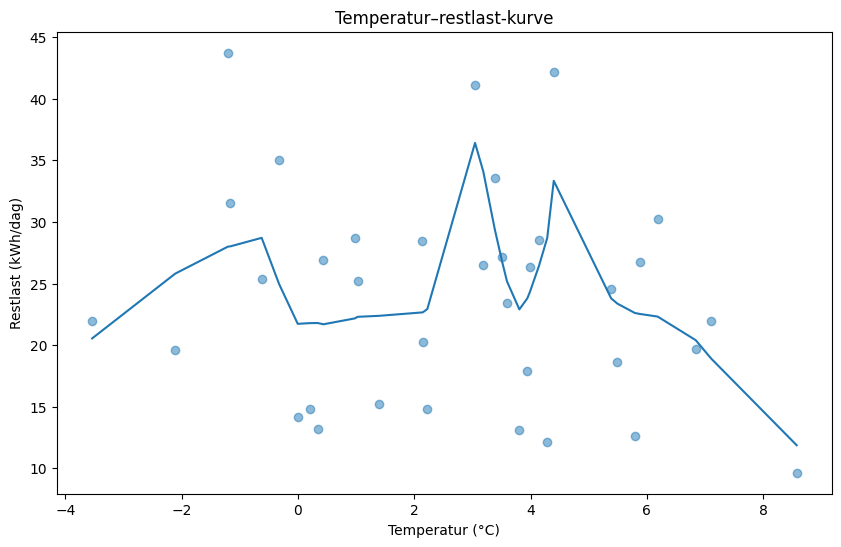

In [72]:
plt.figure(figsize=(10, 6))
plt.scatter(df_anal["air_temperature"], df_anal["Restlast (kWh)"], alpha=0.5)

from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed = lowess(df_anal["Restlast (kWh)"], df_anal["air_temperature"], frac=0.3)

plt.plot(smoothed[:, 0], smoothed[:, 1])
plt.xlabel("Temperatur (°C)")
plt.ylabel("Restlast (kWh/dag)")
plt.title("Temperatur–restlast-kurve")
plt.show()


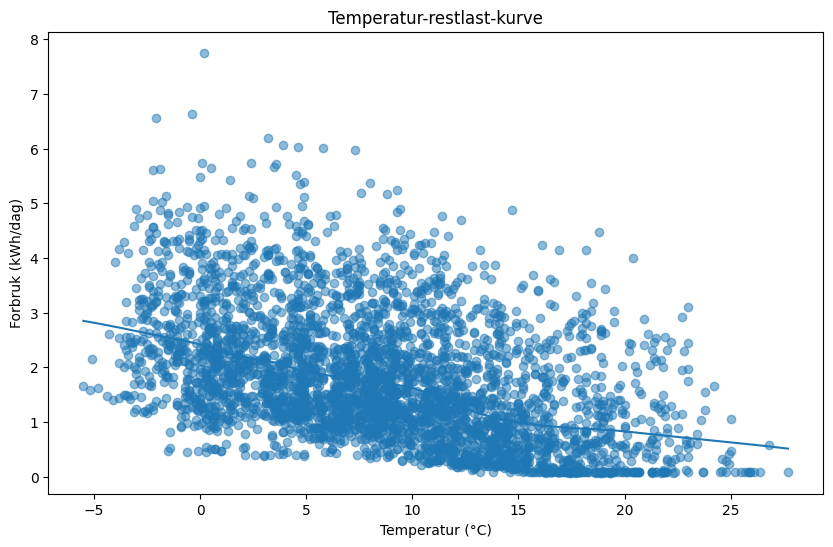

In [73]:
plt.figure(figsize=(10, 6))
plt.scatter(df_forbruk["air_temperature"], df_forbruk["Forbruk (kWh)"], alpha=0.5)

smoothed = lowess(df_forbruk["Forbruk (kWh)"], df_forbruk["air_temperature"], frac=0.3)
plt.plot(smoothed[:, 0], smoothed[:, 1])

plt.xlabel("Temperatur (°C)")
plt.ylabel("Forbruk (kWh/dag)")
plt.title("Temperatur-restlast-kurve")
plt.show()


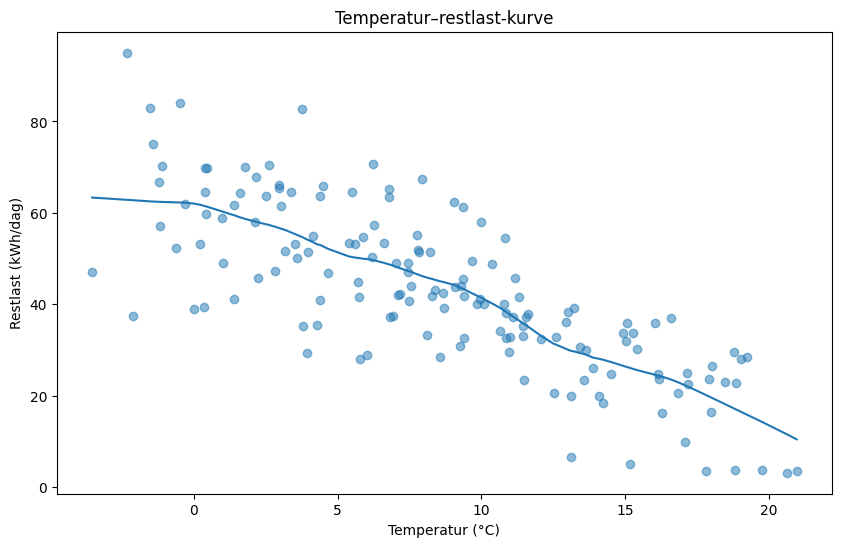

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(df_daily["air_temperature"], df_daily["Forbruk (kWh)"], alpha=0.5)

smoothed = lowess(df_daily["Forbruk (kWh)"], df_daily["air_temperature"], frac=0.3)
plt.plot(smoothed[:, 0], smoothed[:, 1])

plt.xlabel("Temperatur (°C)")
plt.ylabel("Restlast (kWh/dag)")
plt.title("Temperatur–restlast-kurve")
plt.show()


In [75]:
# 1. Lag et sett med kandidater for T_base
T_base_candidates = np.arange(1, 23.5, 0.5)

best_r2 = -np.inf
best_T_base = None

for T in T_base_candidates:
    ferie["HDD"] = (T - ferie["air_temperature"]).clip(lower=0)
    X = sm.add_constant(ferie["HDD"])
    y = ferie["Restlast (kWh)"]

    m = sm.OLS(y, X).fit()

    if m.rsquared > best_r2:
        best_r2 = m.rsquared
        best_T_base = T

print(f"Optimal T_base for OLS-modellen: {best_T_base:.1f} °C med R²={best_r2:.3f}")


Optimal T_base for OLS-modellen: 1.0 °C med R²=0.761


 Konklusjon:

 Selv når ingen er hjemme, er det betydelig strømforbruk.

 Restlasten domineres av varmelast + litt teknisk last.

In [76]:
# Beregn Heating Degree Days basert på T_base vi fant (13 °C)
T_base = 13
ferie["HDD"] = (T_base - ferie["air_temperature"]).clip(lower=0)

# Modell: Forbruk som funksjon av HDD
X = sm.add_constant(ferie["HDD"])
y = ferie["Forbruk (kWh)"]

m = sm.OLS(y, X).fit()
print(m.summary())


                            OLS Regression Results                            
Dep. Variable:          Forbruk (kWh)   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     20.46
Date:                Wed, 18 Feb 2026   Prob (F-statistic):            0.00272
Time:                        15:31:23   Log-Likelihood:                -23.143
No. Observations:                   9   AIC:                             50.29
Df Residuals:                       7   BIC:                             50.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8441      3.915      5.325      0.0

In [77]:
T_base = 13
ferie["HDD"] = (T_base - ferie["air_temperature"]).clip(lower=0)

X = sm.add_constant(ferie["HDD"])
y = ferie["Restlast (kWh)"]

m = sm.OLS(y, X).fit()
print(m.summary())


                            OLS Regression Results                            
Dep. Variable:         Restlast (kWh)   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     21.57
Date:                Wed, 18 Feb 2026   Prob (F-statistic):            0.00236
Time:                        15:31:24   Log-Likelihood:                -16.866
No. Observations:                   9   AIC:                             37.73
Df Residuals:                       7   BIC:                             38.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4748      1.949      2.809      0.0

 Ikke tenkt for dypt på HDD konstanten.

 Intuisjon: ved T_ute = T_base trenger du ikke ekstra varme utover "baseline" for å holde stabilt.

 Energiforbruket til én ovn er estimert for deler av perioden, noe som introduserer usikkerhet i konstantleddet,

 men har begrenset effekt på estimert temperaturfølsomhet.

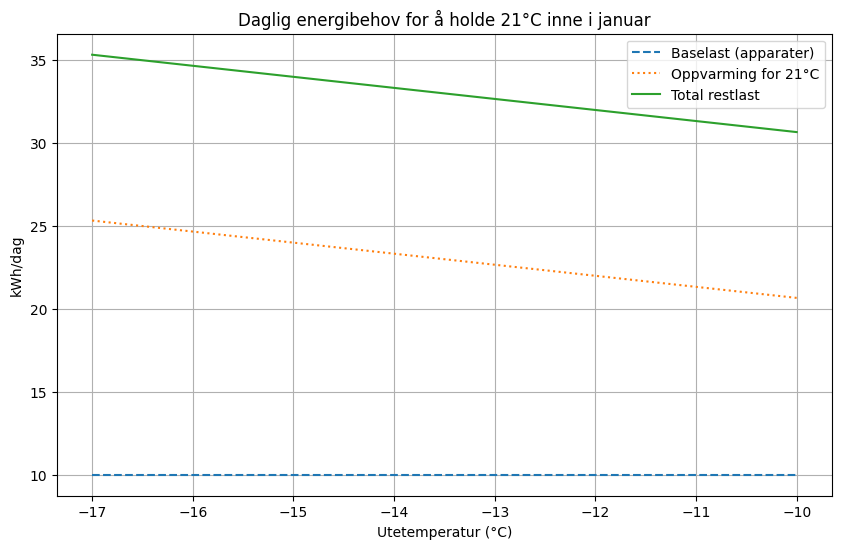

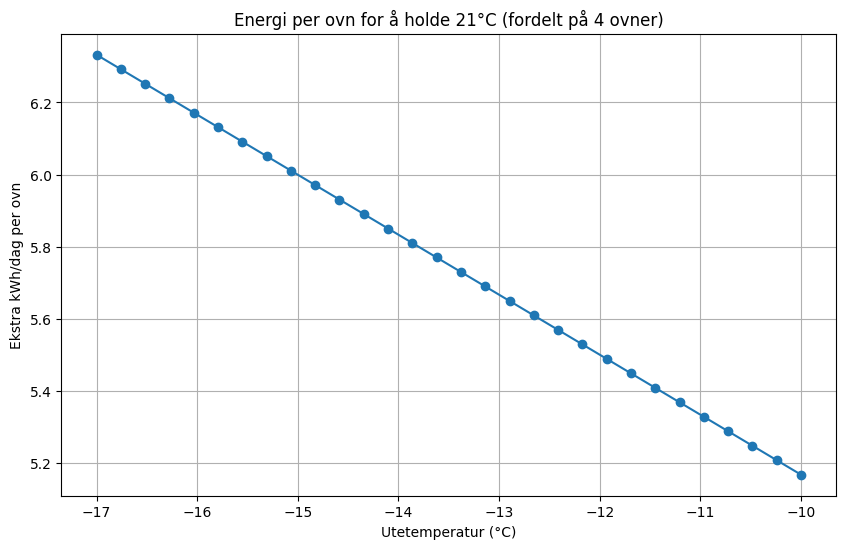

Total ekstra oppvarming for januar: 689.9 kWh
Totalkostnad for dårlig isolasjon i januar: 690 kr


In [78]:
# --- Parametre basert på analysen ---
T_base = 21          # Ønsket innetemperatur
beta_HDD = 0.6666    # kWh/dag per kuldegrad (fra OLS)
baseline = 10        # Baselast kWh/dag (apparater)
num_ovner = 4        # Antall ovner
ovns_effekt = 1.2    # kW per ovn, illustrasjon
pris_per_kWh = 1     # kroner/kWh

# --- Faktiske utetemperaturer for januar (eksempeldata, 30 dager) ---
T_ute = np.linspace(-17, -10, 30)

# --- Beregn HDD basert på ønsket innetemperatur ---
HDD = np.clip(T_base - T_ute, 0, None)

# --- Beregn ekstra oppvarmingsbehov og total restlast ---
oppvarming = beta_HDD * HDD
total_restlast = baseline + oppvarming

# --- Visualisering: Energi vs utetemperatur ---
plt.figure(figsize=(10, 6))
plt.plot(T_ute, baseline * np.ones_like(T_ute), label="Baselast (apparater)", linestyle="--")
plt.plot(T_ute, oppvarming, label="Oppvarming for 21°C", linestyle=":")
plt.plot(T_ute, total_restlast, label="Total restlast", linestyle="-")
plt.xlabel("Utetemperatur (°C)")
plt.ylabel("kWh/dag")
plt.title("Daglig energibehov for å holde 21°C inne i januar")
plt.legend()
plt.grid(True)
plt.show()

# --- Belastning per ovn ---
ovn_last = oppvarming / num_ovner

plt.figure(figsize=(10, 6))
plt.plot(T_ute, ovn_last, marker="o")
plt.xlabel("Utetemperatur (°C)")
plt.ylabel("Ekstra kWh/dag per ovn")
plt.title(f"Energi per ovn for å holde 21°C (fordelt på {num_ovner} ovner)")
plt.grid(True)
plt.show()

# --- Kostnad for januar (30 dager) ---
total_oppvarming_30d = np.sum(oppvarming)
kostnad = total_oppvarming_30d * pris_per_kWh

print(f"Total ekstra oppvarming for januar: {total_oppvarming_30d:.1f} kWh")
print(f"Totalkostnad for dårlig isolasjon i januar: {kostnad:.0f} kr")
